In [73]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [74]:
bolTrainagain = False # will try to load data if false 

In [75]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=0
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4961.598765432074
Friday area:  4076.986111111094
Weekend area:  862.1666666666708
Weekday maximum:  217.03703703703704
Friday maximum:  187.5
Weekend maximum:  36.92857142857143


## MATHEMATICAL MODEL - CDF Subtraction

In [76]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                 errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})


In [77]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00172



In [78]:
optimal_params_weekdaytn

 final_simplex: (array([[0.28858668, 0.05259237, 0.77801314, 0.12862852],
       [0.28858664, 0.05259241, 0.77801298, 0.12862771],
       [0.28858672, 0.05259248, 0.77801267, 0.12862844],
       [0.28858682, 0.05259259, 0.77801305, 0.12862848],
       [0.28858667, 0.05259265, 0.77801295, 0.12862873]]), array([0.00385085, 0.00385085, 0.00385085, 0.00385085, 0.00385085]))
           fun: 0.003850845642572666
       message: 'Optimization terminated successfully.'
          nfev: 275
           nit: 161
        status: 0
       success: True
             x: array([0.28858668, 0.05259237, 0.77801314, 0.12862852])

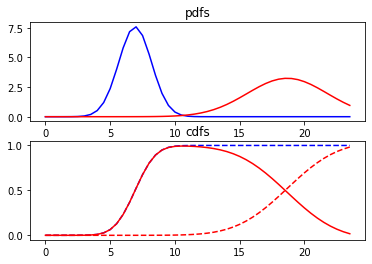

In [79]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [80]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.28858668, 0.05259237, 0.77801314, 0.12862852])

In [81]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


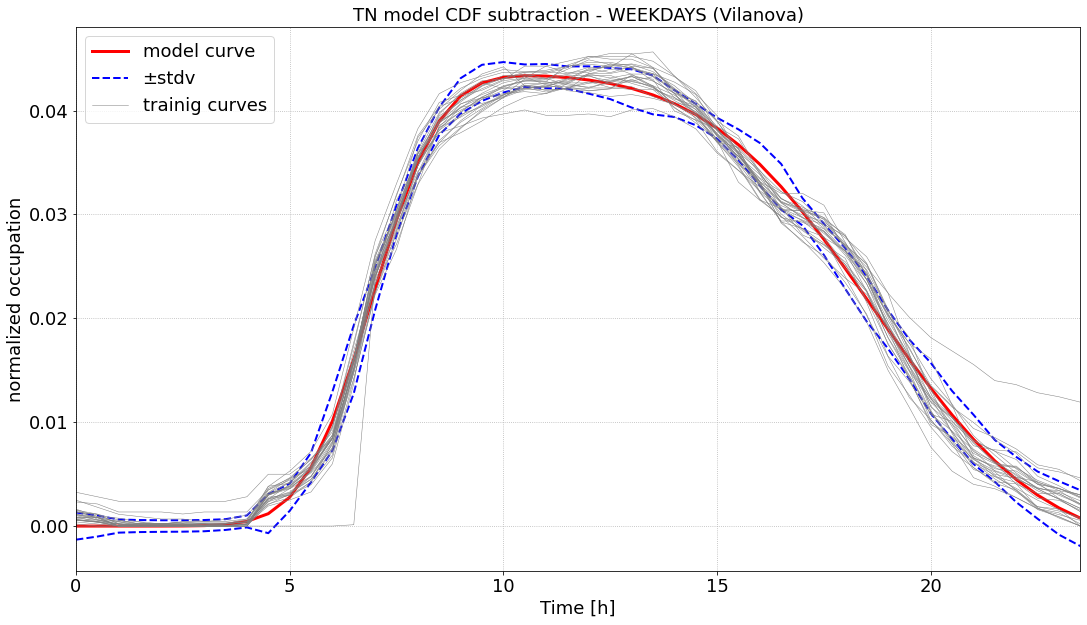

In [82]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [83]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))
    optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


In [84]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00297

stdv per time-step


In [85]:
optimal_params_fridaytn

 final_simplex: (array([[0.29337416, 0.06573958, 0.72696181, 0.14788074],
       [0.29337433, 0.06573973, 0.72696146, 0.14788037],
       [0.2933744 , 0.06573937, 0.72696165, 0.14788072],
       [0.29337441, 0.06573955, 0.72696112, 0.14788109],
       [0.29337463, 0.06573957, 0.72696175, 0.14788156]]), array([0.00254407, 0.00254407, 0.00254407, 0.00254407, 0.00254407]))
           fun: 0.00254406806367286
       message: 'Optimization terminated successfully.'
          nfev: 246
           nit: 144
        status: 0
       success: True
             x: array([0.29337416, 0.06573958, 0.72696181, 0.14788074])

In [86]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [87]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

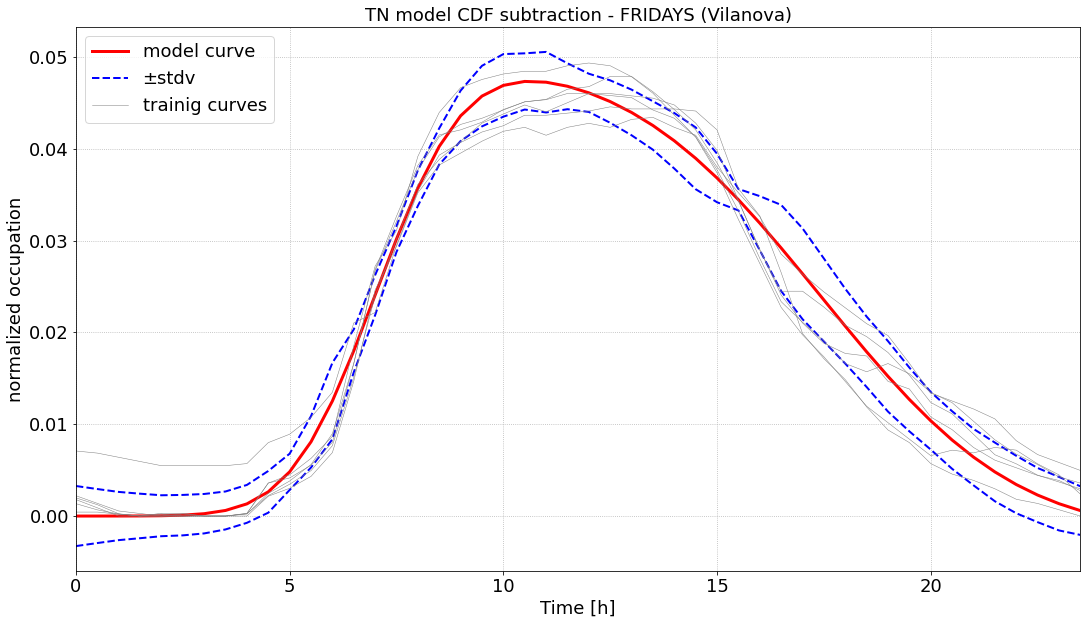

In [88]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [89]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))    
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
        #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     

        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
        

## save the model fits

In [90]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFit.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [91]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.00602



In [92]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([3.26647331e-01, 1.25292000e-01, 1.03715781e+04, 3.04270639e+01])

In [93]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



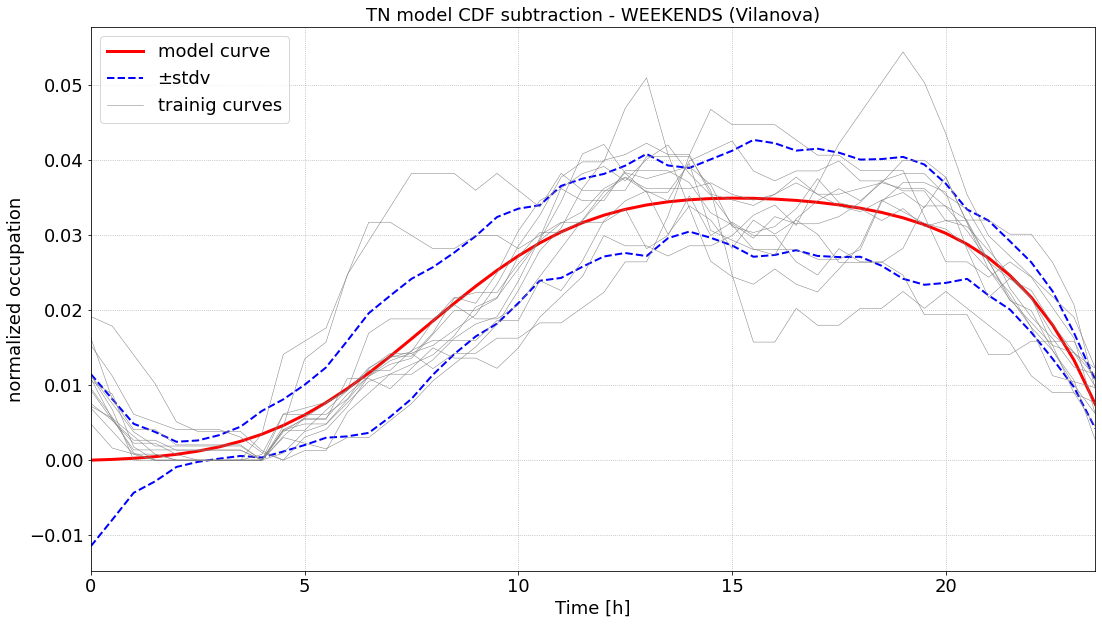

In [94]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [95]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Vilanova -----------
Mean Arrival Time   = 06:55h
stdv Arrival        =  1:15h
Mean Departure Time = 18:40h
stdv Departure      =  3:05h
--------- FRIDAYS Vilanova -----------
Mean Arrival Time   = 07:02h
stdv Arrival        =  1:34h
Mean Departure Time = 17:26h
stdv Departure      =  3:32h
--------- WEEKENDS Vilanova -----------
Mean Arrival Time   = 07:50h
stdv Arrival        =  3:00h
Mean Departure Time = 248917:52h
stdv Departure      = 730:14h


In [96]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [97]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [98]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [99]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
4.976219699641576  ±  2.7671827478426727
3.043072621015494  ±  1.336584591195966
2.3160598487431017  ±  1.3099823064284342
2.6910438924194025  ±  1.4468808886419329
4.356133082320792  ±  2.7627092318033846
2.932897642588005  ±  1.3246742994076983
4.683807886818376  ±  1.8555797351931684


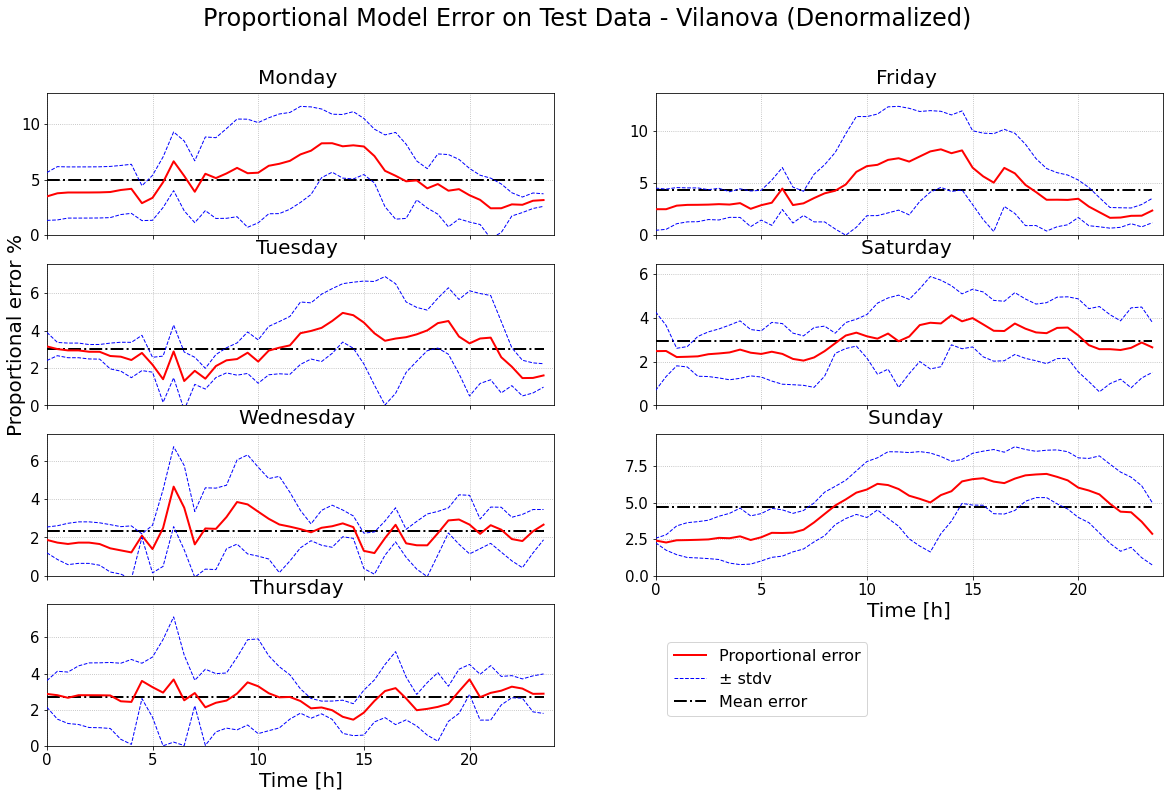

In [100]:
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [101]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [102]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [103]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

#### MONDAY

In [104]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 14
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-24
Real Monday scaled prtotype error:  2.63 %
Real Monday scaled prtotype STDV:  1.4676127766192288
Real Monday scaled TN error:  4.12 %
Real Monday scaled TN STDV:  4.64451879708703
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  21.8 %
Real Monday scaled prtotype STDV:  13.59387313976335
Real Monday scaled TN error:  22.3 %
Real Monday scaled TN STDV:  16.031296967821817
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  8.87 %
Real Monday scaled prtotype STDV:  5.514930937197236
Real Monday scaled TN error:  9.33 %
Real Monday scaled TN STDV:  8.332347835278346
_____________________________________________________________


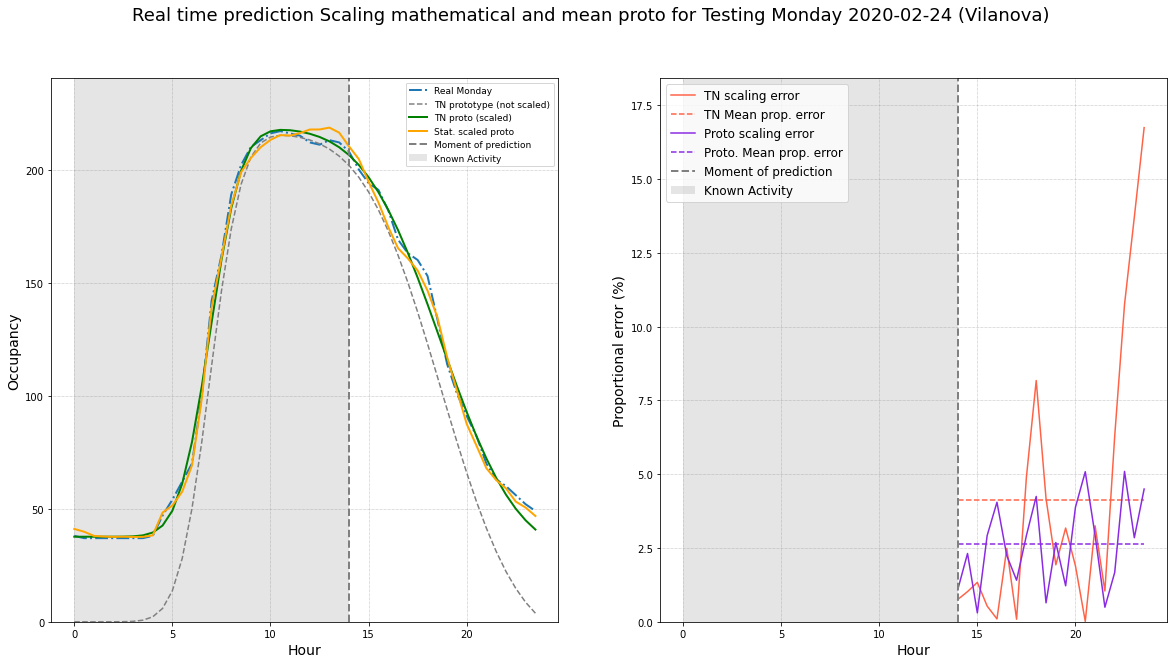

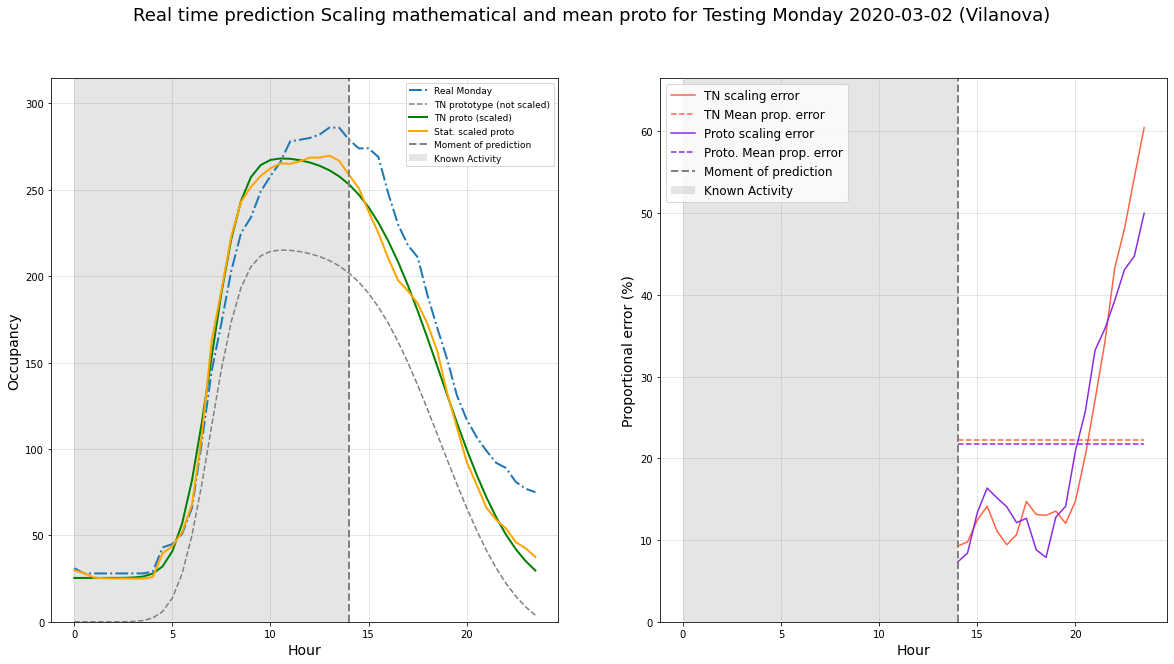

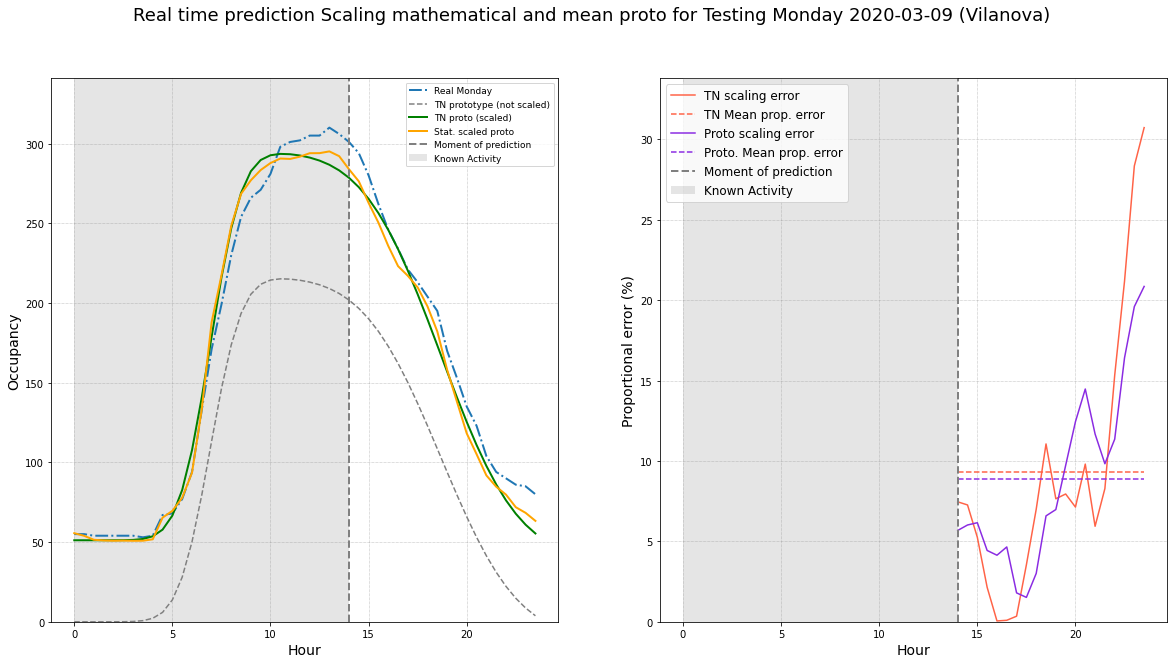

In [105]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [106]:
starting_hour=7

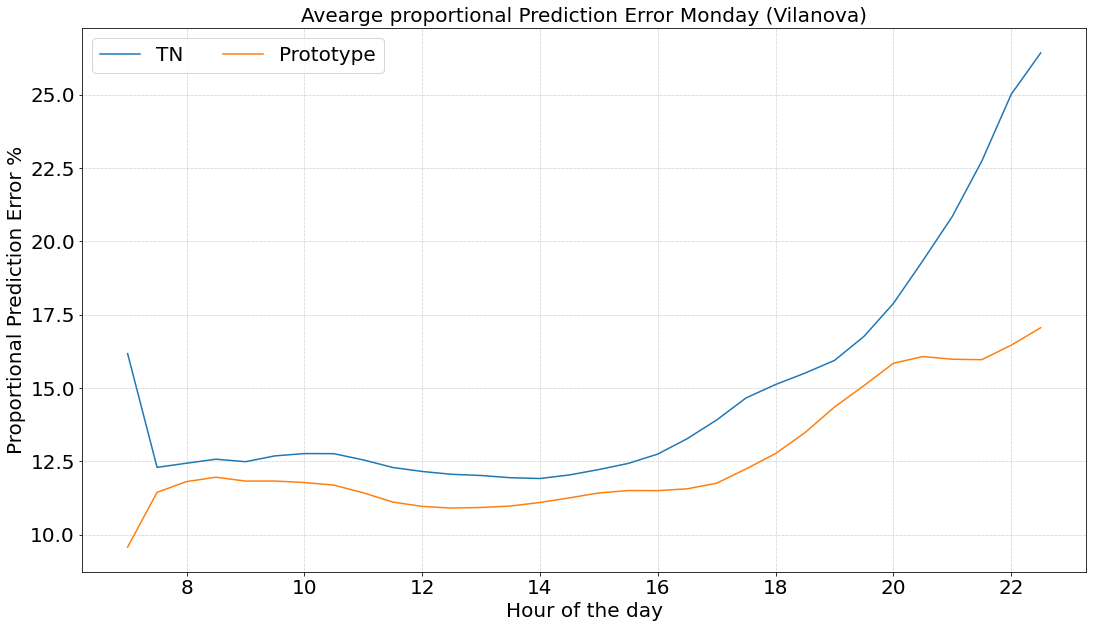

In [107]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [108]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

2020-02-24
Real Monday scaled prtotype error:  6.08 %
Real Monday scaled prtotype STDV:  5.362902496295517
Real Monday scaled TN error:  4.68 %
Real Monday scaled TN STDV:  3.9776210527109357
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  4.66 %
Real Monday scaled prtotype STDV:  3.103648203459637
Real Monday scaled TN error:  5.19 %
Real Monday scaled TN STDV:  4.196767261685183
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  3.79 %
Real Monday scaled prtotype STDV:  2.9381156163470554
Real Monday scaled TN error:  5.47 %
Real Monday scaled TN STDV:  3.452574713066785
_____________________________________________________________


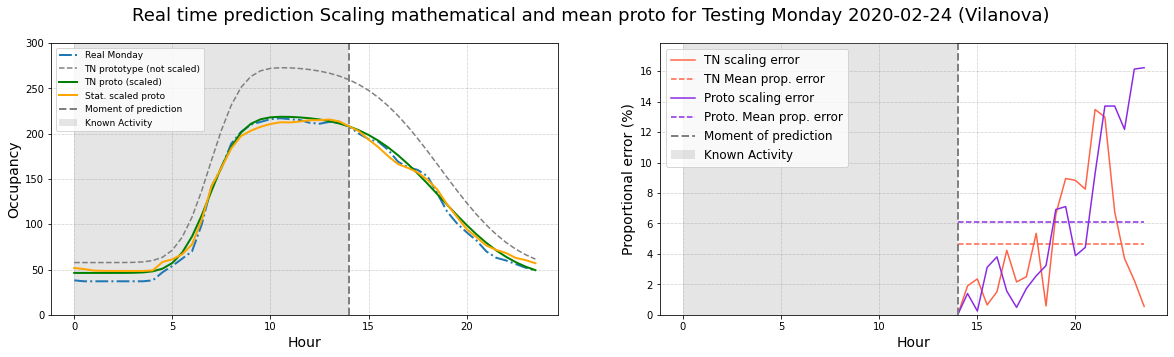

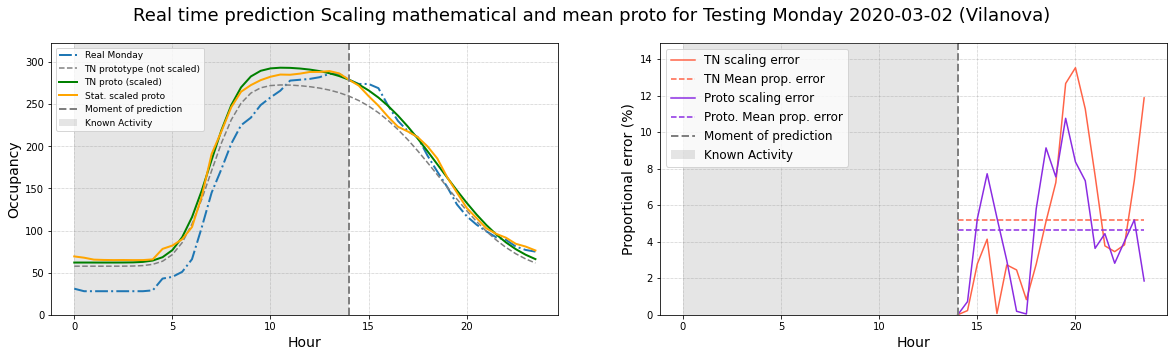

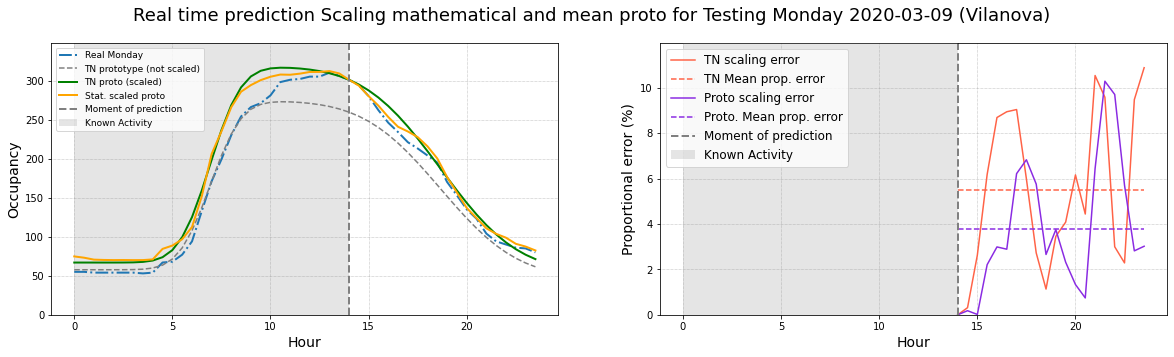

In [109]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

2020-02-24


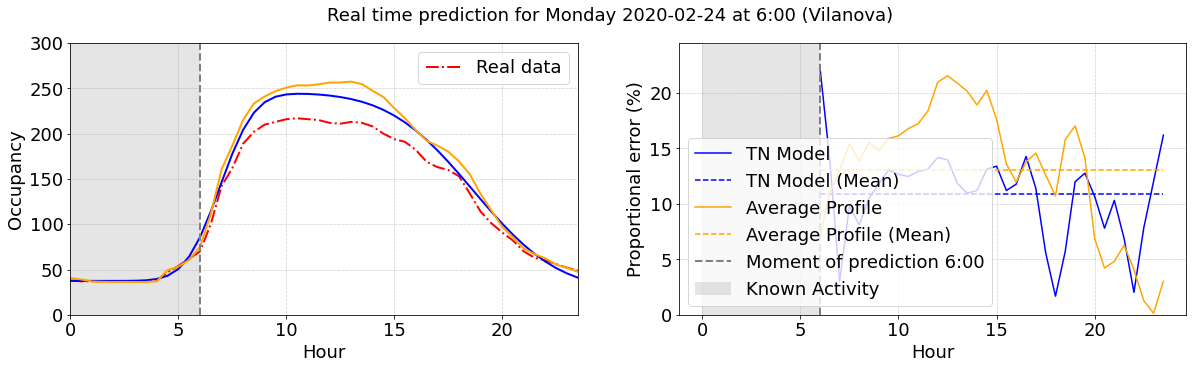

In [113]:
limit_hour = 6
fsize=18


if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

cont=0
i=0



t_date=t_dates[cont]
print(t_date)
tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]


#scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='Real data')

ax[axx].plot(time, scaled_tn_proto, color='blue', linewidth=2) #, label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2) #, label='Average Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].legend(fontsize=fsize)
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto),
                             max(scaled_stat_proto)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
axx=1;



limit_hourIdx = int(limit_hour*2)
#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/max_value)*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue', label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange', label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Average Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Moment of prediction '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].legend(fontsize=fsize)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

#### TUESDAY

In [39]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-25
Real Tuesday scaled prtotype error:  8.05 %
Real Tuesday scaled prtotype STDV:  5.042318853640873
Real Tuesday scaled TN error:  7.95 %
Real Tuesday scaled TN STDV:  6.801673071957551
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  1.89 %
Real Tuesday scaled prtotype STDV:  2.335476079364648
Real Tuesday scaled TN error:  2.1 %
Real Tuesday scaled TN STDV:  1.712934530731834
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  6.37 %
Real Tuesday scaled prtotype STDV:  6.155274836913296
Real Tuesday scaled TN error:  5.57 %
Real Tuesday scaled TN STDV:  3.9247425577360895
_____________________________________________________________


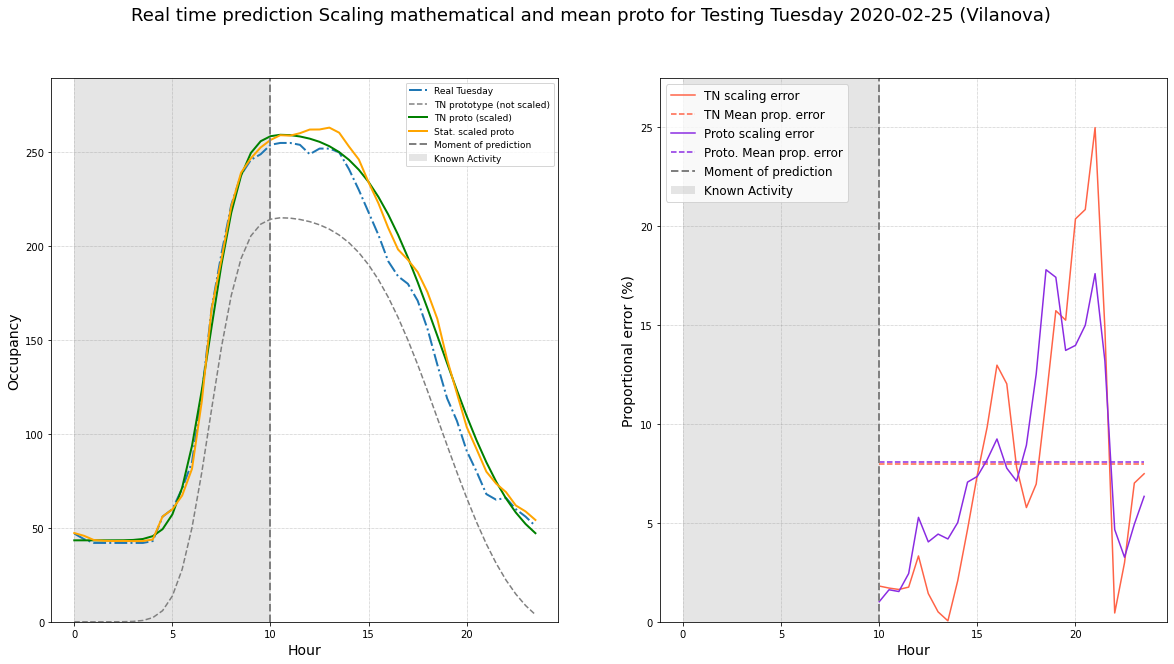

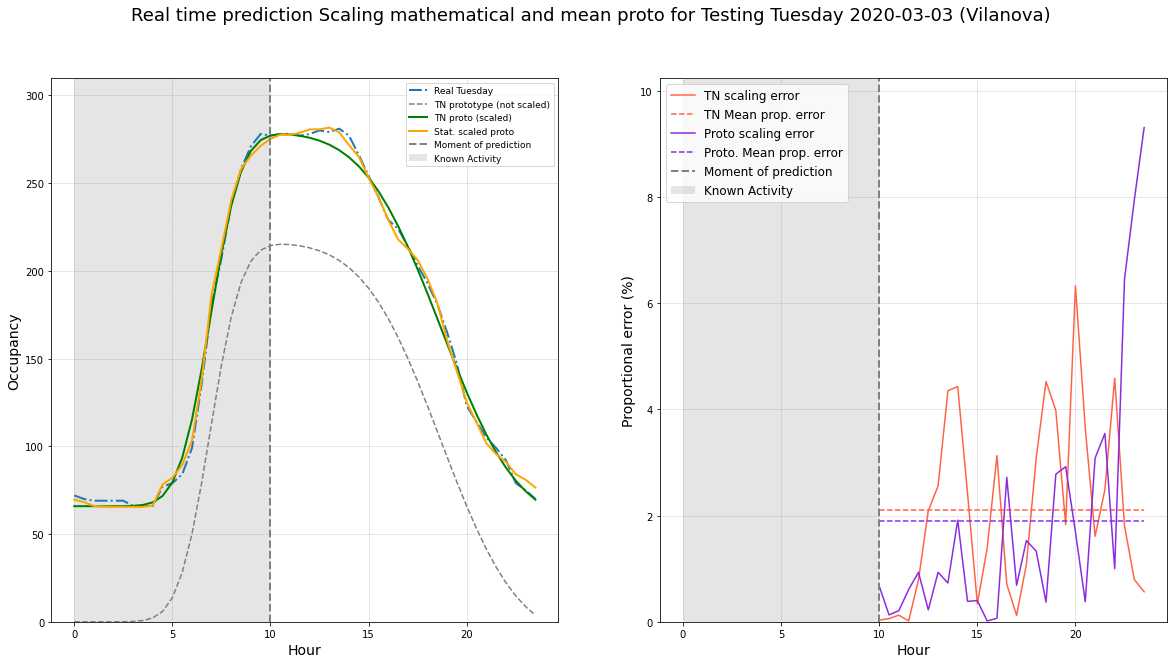

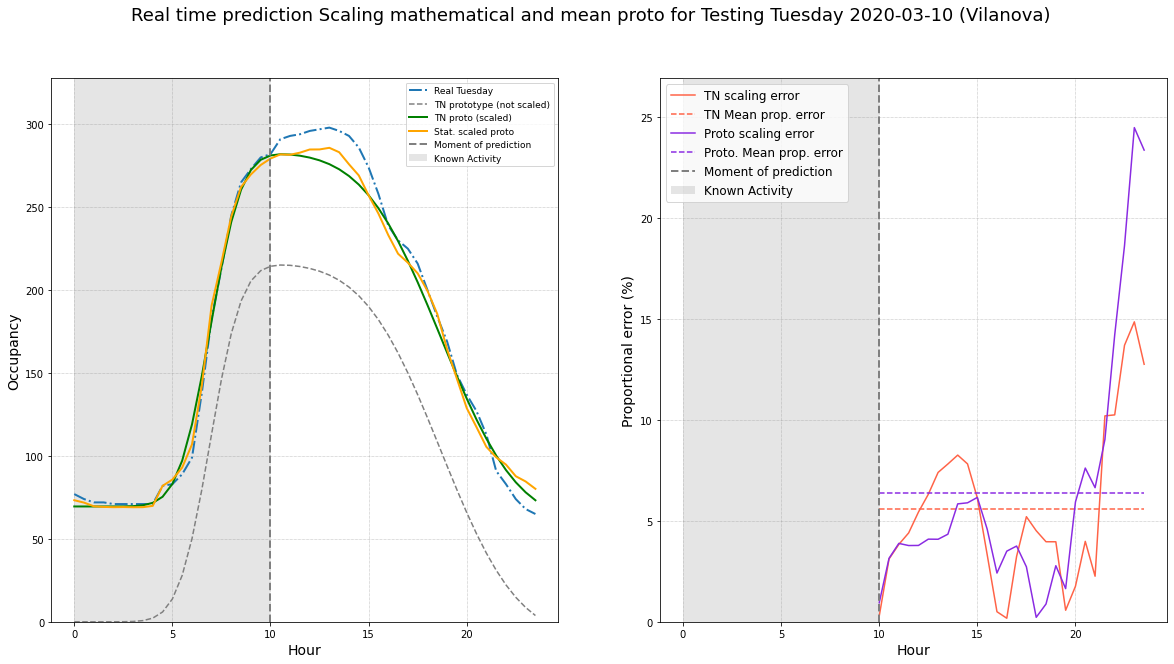

In [40]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

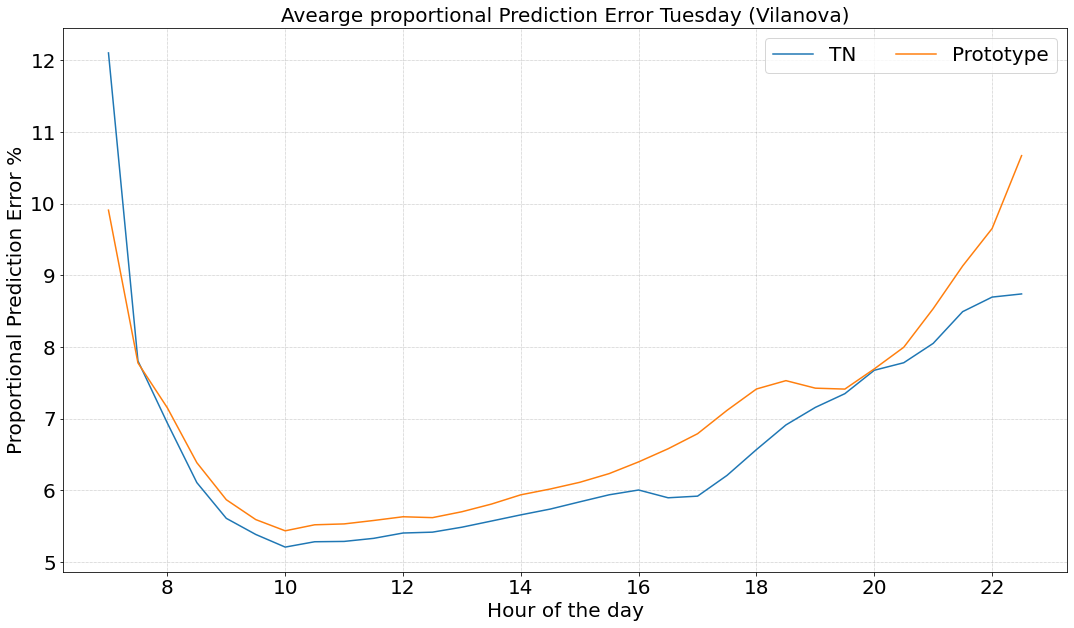

In [41]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [42]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-25
Real Tuesday scaled prtotype error:  14.3 %
Real Tuesday scaled prtotype STDV:  11.70726665643812
Real Tuesday scaled TN error:  10.35 %
Real Tuesday scaled TN STDV:  9.887532480542605
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  1.9 %
Real Tuesday scaled prtotype STDV:  1.8308786109599609
Real Tuesday scaled TN error:  3.66 %
Real Tuesday scaled TN STDV:  3.349260055694409
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  5.36 %
Real Tuesday scaled prtotype STDV:  4.691229342671722
Real Tuesday scaled TN error:  4.64 %
Real Tuesday scaled TN STDV:  2.8704141623502686
_____________________________________________________________


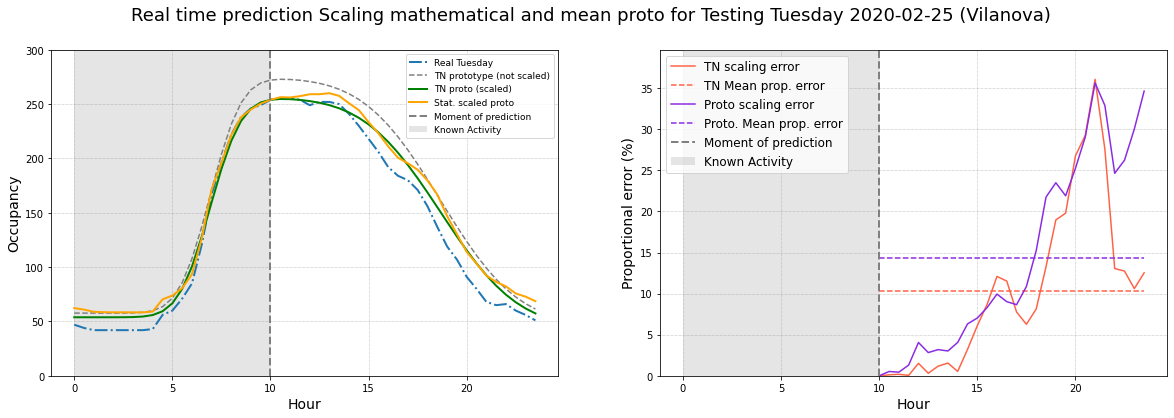

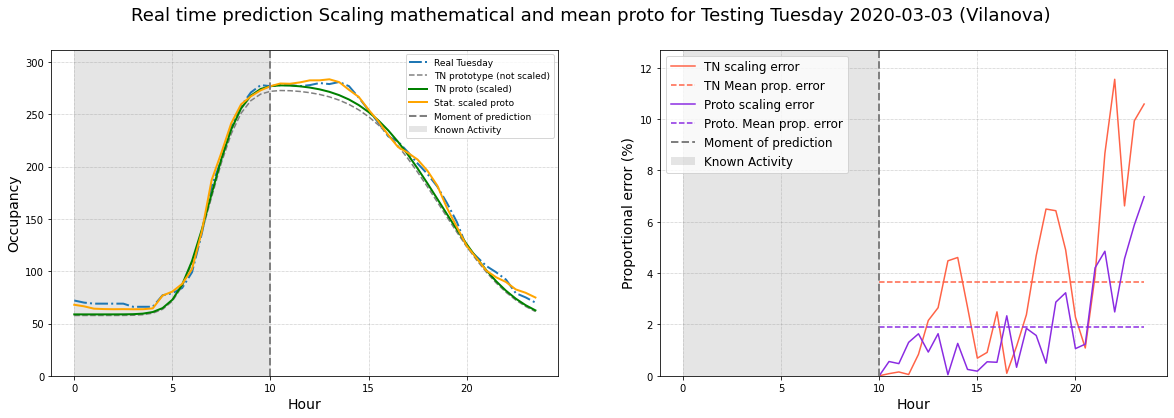

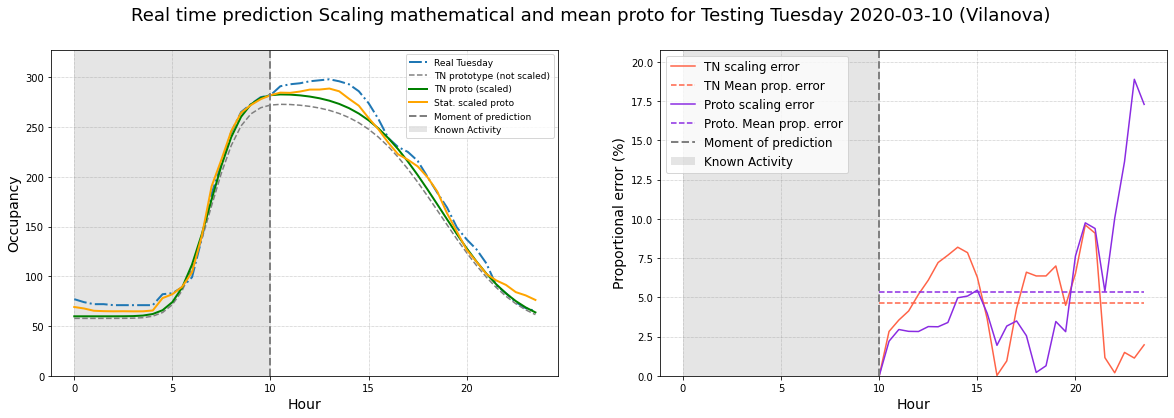

In [43]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

In [44]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-26
Real Wednesday scaled prtotype error:  6.41 %
Real Wednesday scaled prtotype STDV:  3.8818691427735286
Real Wednesday scaled TN error:  4.68 %
Real Wednesday scaled TN STDV:  3.168364598850536
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  5.63 %
Real Wednesday scaled prtotype STDV:  2.873876832486936
Real Wednesday scaled TN error:  6.74 %
Real Wednesday scaled TN STDV:  3.7182283023530767
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  5.82 %
Real Wednesday scaled prtotype STDV:  4.559064089631991
Real Wednesday scaled TN error:  6.55 %
Real Wednesday scaled TN STDV:  5.037053250529185
_____________________________________________________________


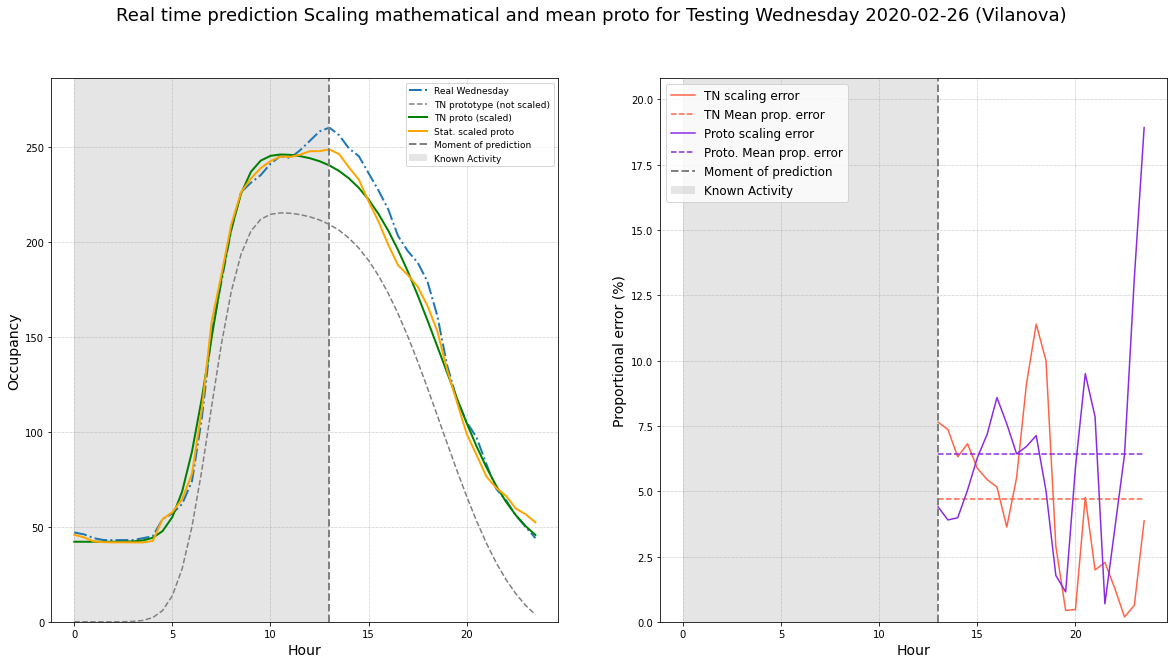

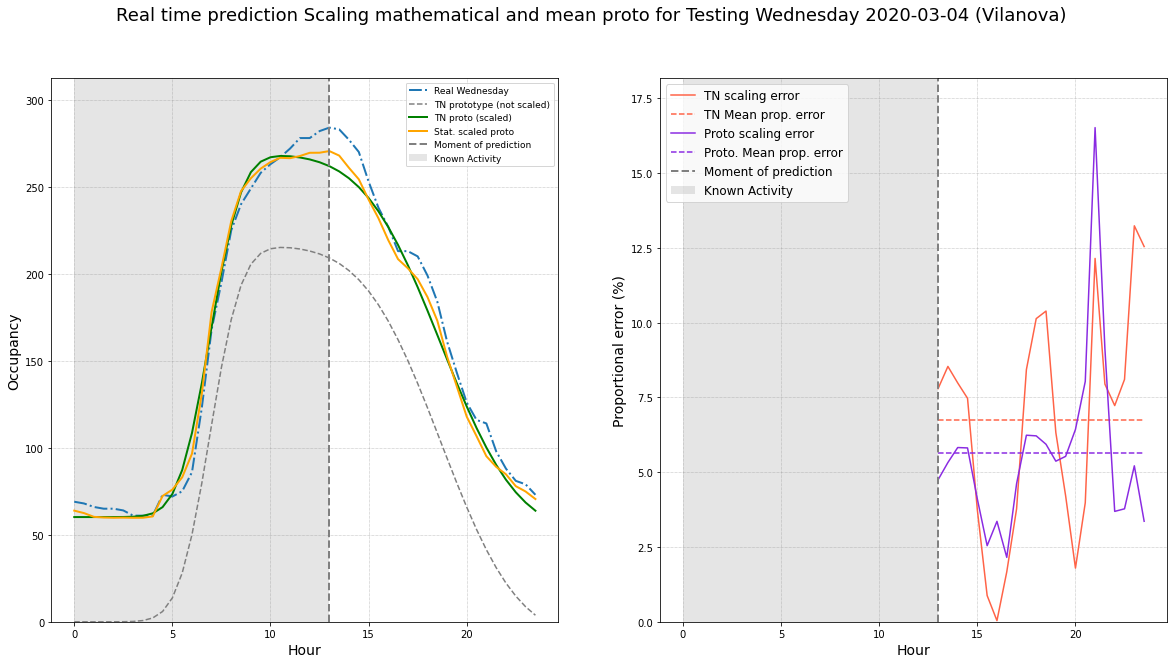

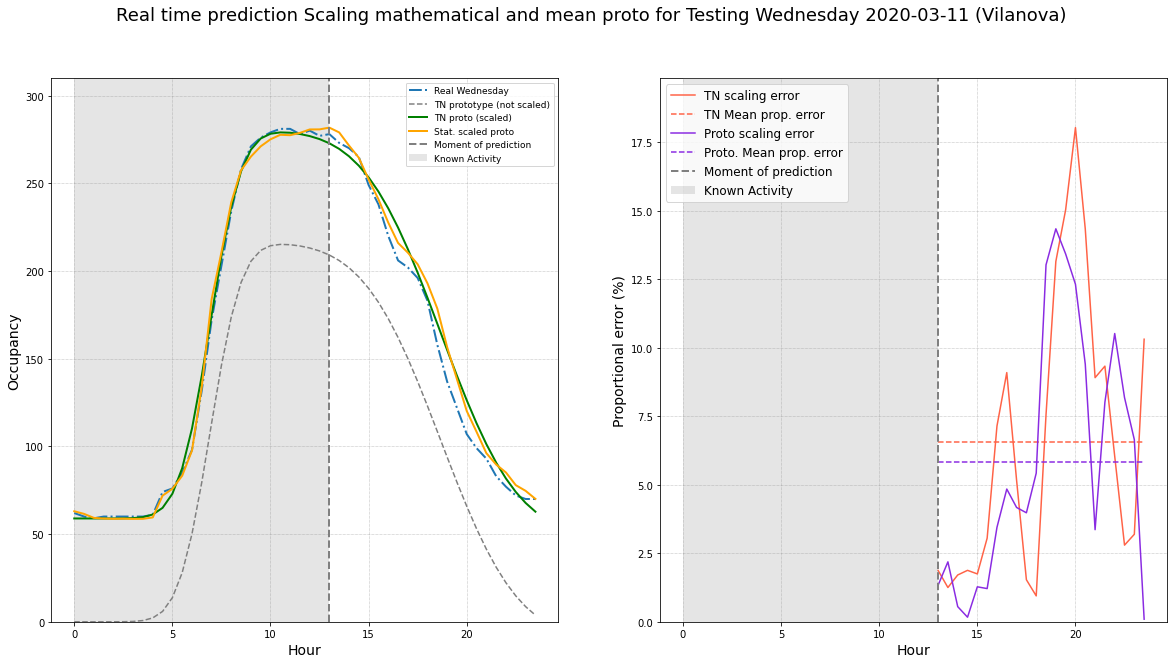

In [45]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

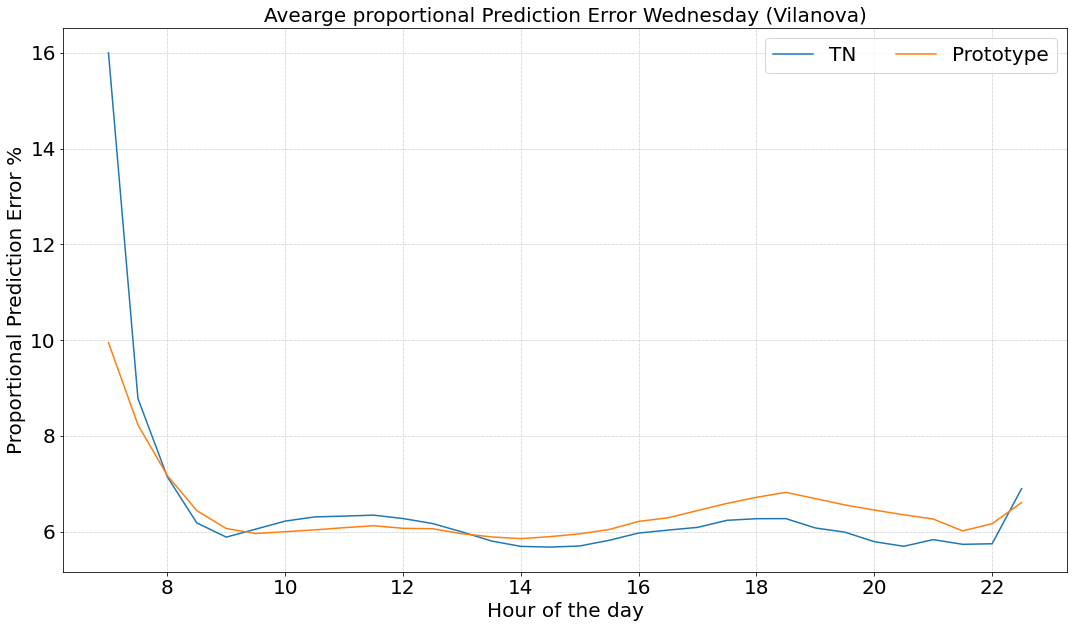

In [46]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [47]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-26
Real Wednesday scaled prtotype error:  11.28 %
Real Wednesday scaled prtotype STDV:  15.812605573554087
Real Wednesday scaled TN error:  10.33 %
Real Wednesday scaled TN STDV:  10.710064911628141
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  1.91 %
Real Wednesday scaled prtotype STDV:  2.333915734796176
Real Wednesday scaled TN error:  4.17 %
Real Wednesday scaled TN STDV:  3.3225354824295046
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  6.78 %
Real Wednesday scaled prtotype STDV:  5.410596616001544
Real Wednesday scaled TN error:  7.64 %
Real Wednesday scaled TN STDV:  5.929048537062244
_____________________________________________________________


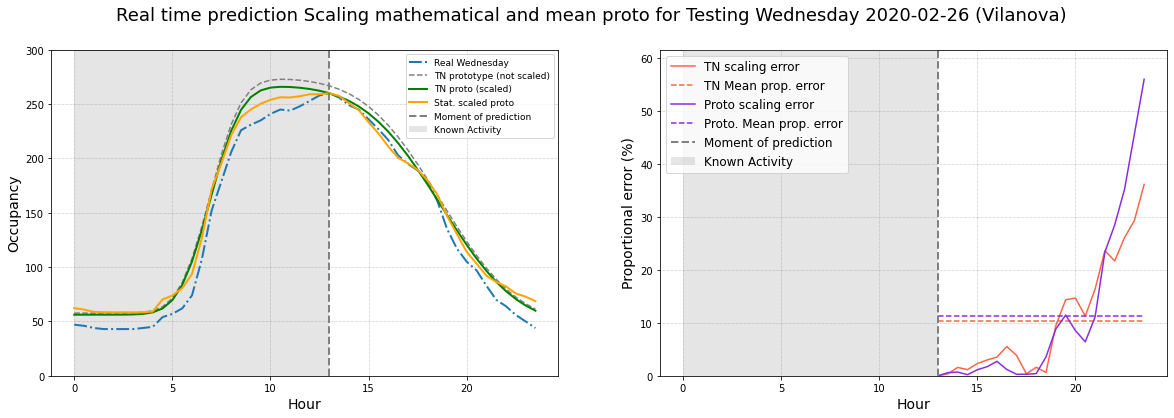

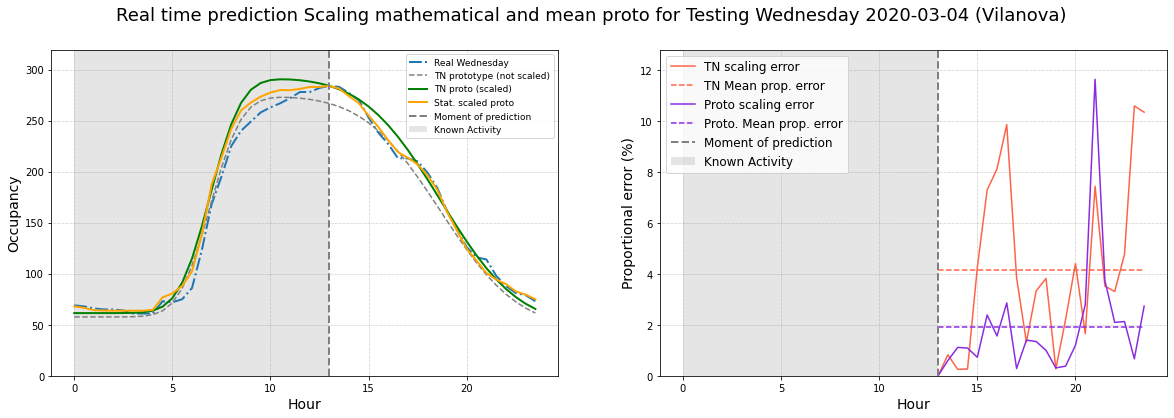

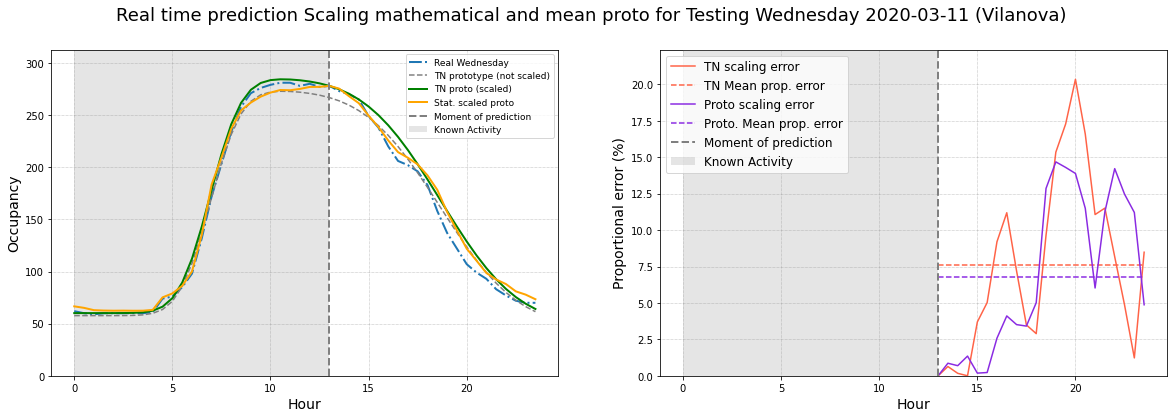

In [48]:
tn_proto = tn_weekday
cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

In [49]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-27
Real Thursday scaled prtotype error:  6.38 %
Real Thursday scaled prtotype STDV:  4.98286260827005
Real Thursday scaled TN error:  16.08 %
Real Thursday scaled TN STDV:  3.4892513733550716
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  3.24 %
Real Thursday scaled prtotype STDV:  1.7695078291542314
Real Thursday scaled TN error:  7.09 %
Real Thursday scaled TN STDV:  2.7088363091089596
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  10.41 %
Real Thursday scaled prtotype STDV:  10.1535753751742
Real Thursday scaled TN error:  9.88 %
Real Thursday scaled TN STDV:  7.164434237249501
_____________________________________________________________


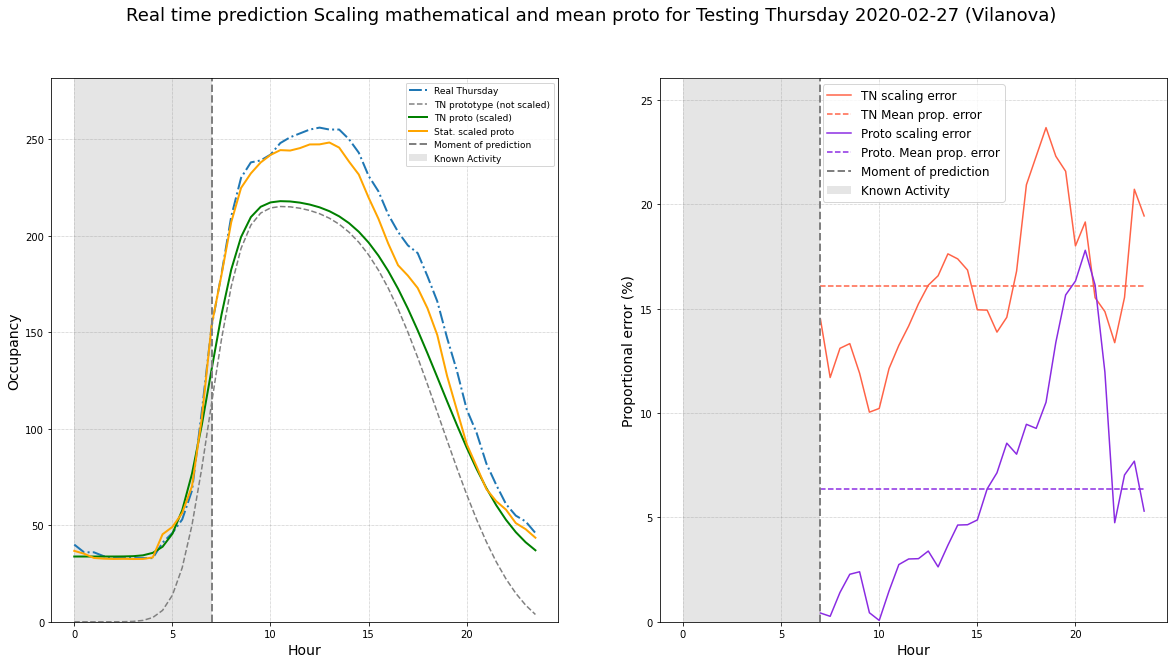

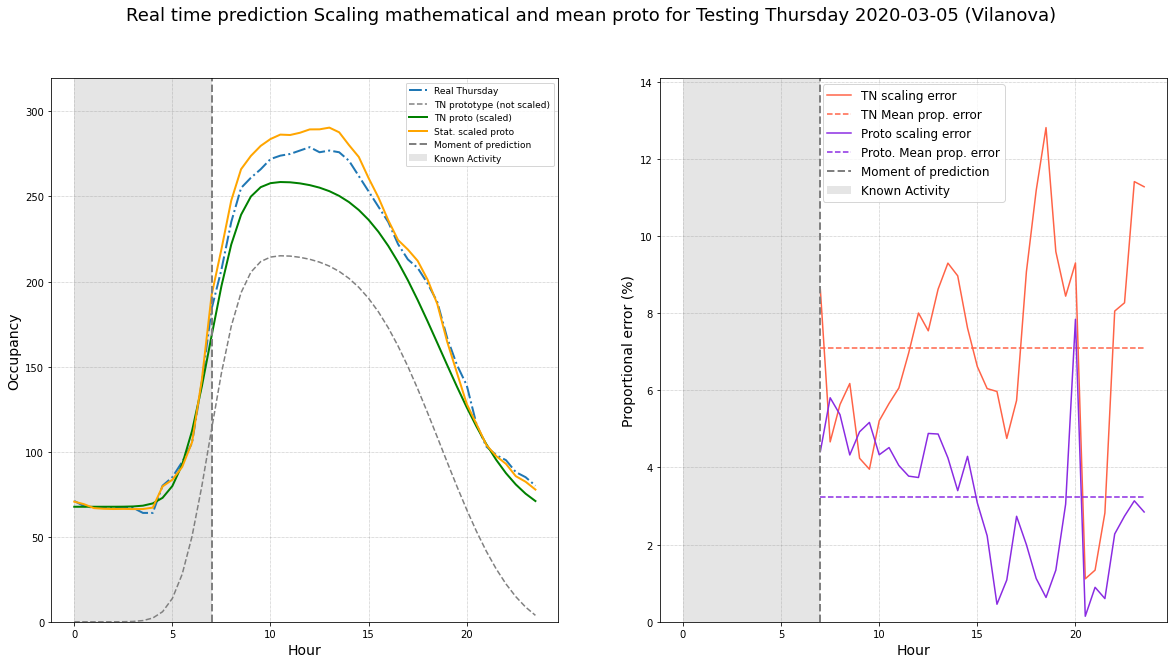

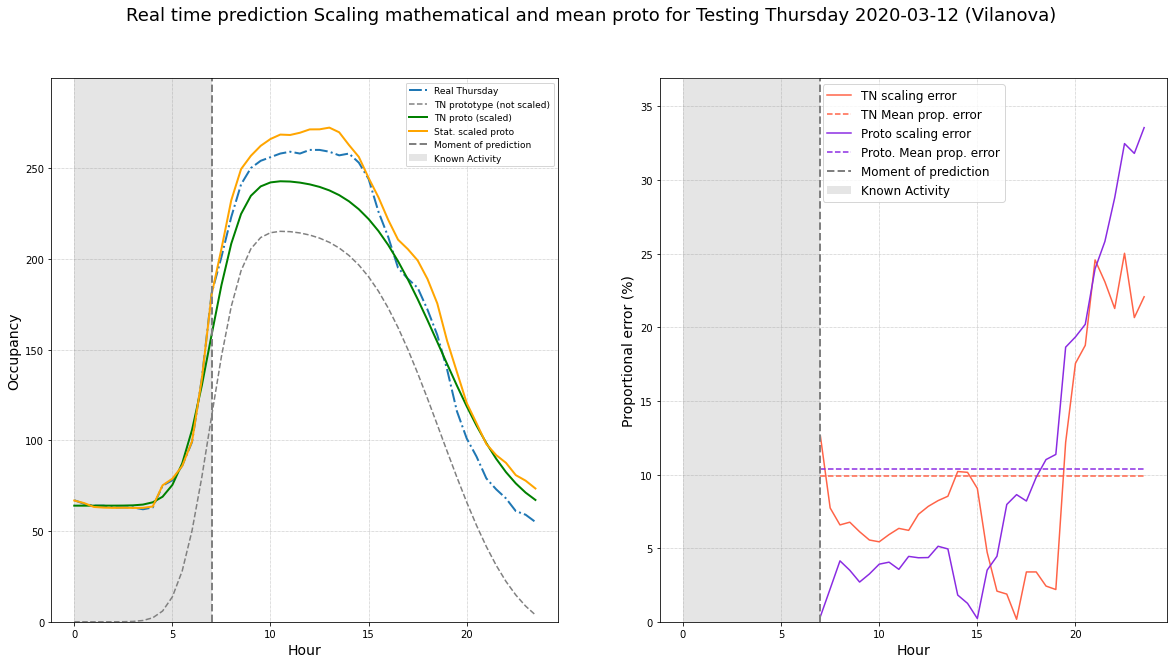

In [50]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

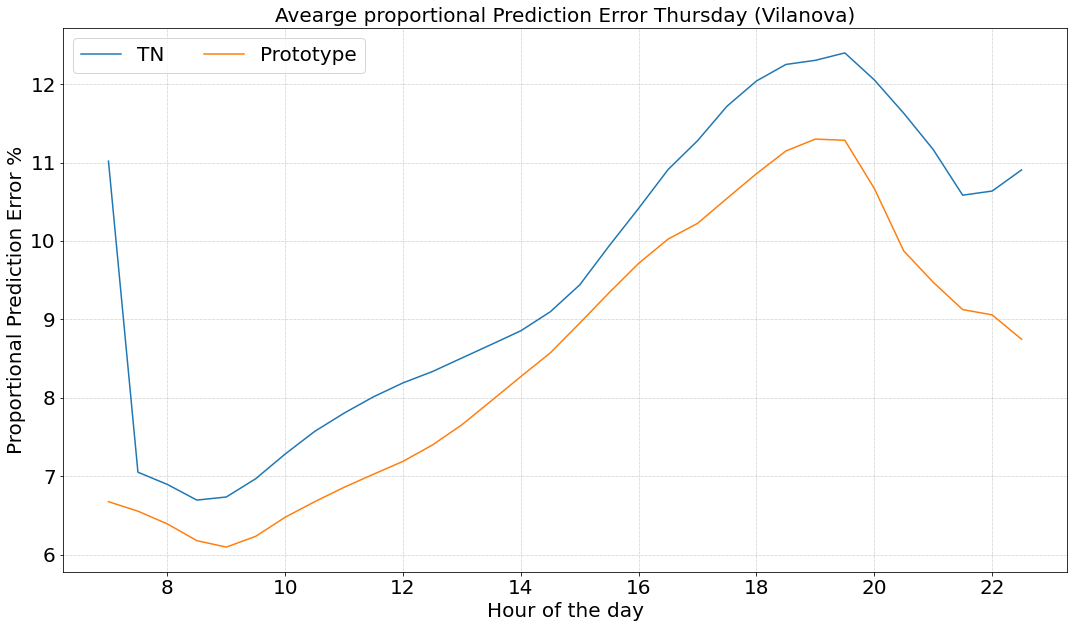

In [51]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [52]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

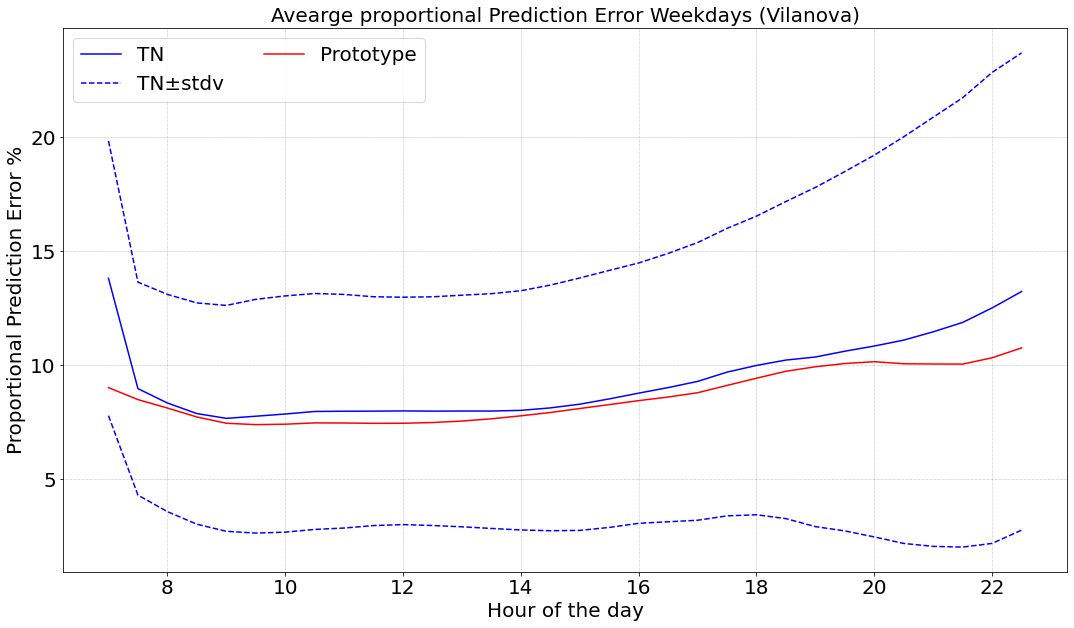

In [53]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

2020-02-27
Real Thursday scaled prtotype error:  10.4 %
Real Thursday scaled prtotype STDV:  6.304757751093223
Real Thursday scaled TN error:  6.0 %
Real Thursday scaled TN STDV:  5.153472118517422
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  2.92 %
Real Thursday scaled prtotype STDV:  3.0739466366934205
Real Thursday scaled TN error:  5.69 %
Real Thursday scaled TN STDV:  3.6716475298293227
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  10.59 %
Real Thursday scaled prtotype STDV:  9.423193436555637
Real Thursday scaled TN error:  14.77 %
Real Thursday scaled TN STDV:  7.731561581774946
_____________________________________________________________


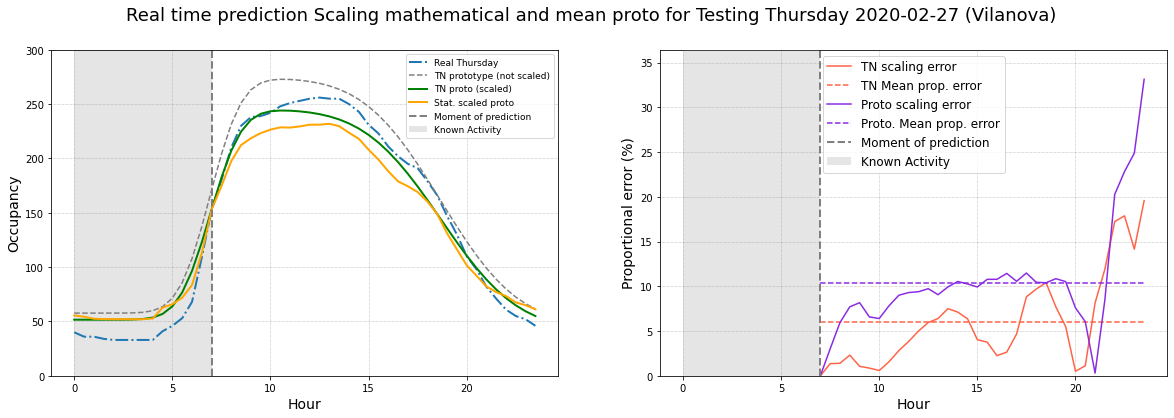

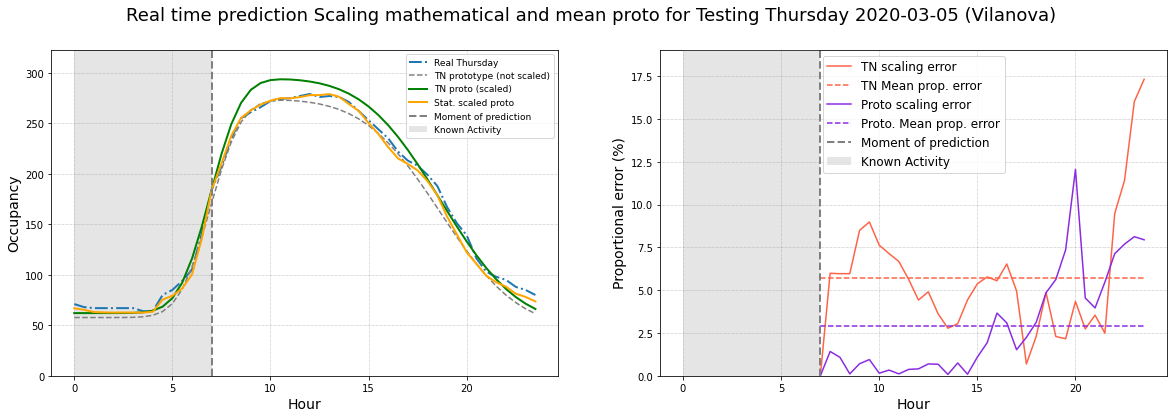

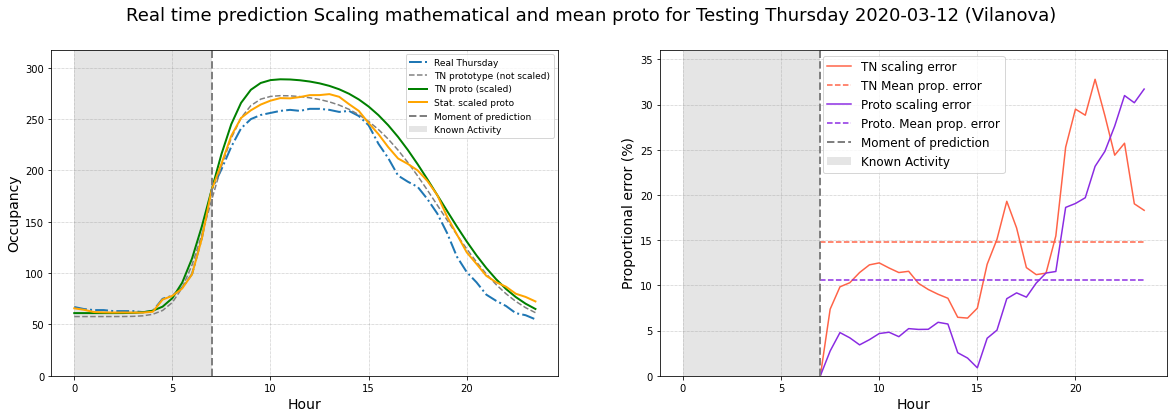

In [54]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

In [55]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday_nooff
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-28
Real Friday scaled prtotype error:  7.62 %
Real Friday scaled prtotype STDV:  4.529428667860805
Real Friday scaled TN error:  14.56 %
Real Friday scaled TN STDV:  9.131430627489216
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  8.86 %
Real Friday scaled prtotype STDV:  3.5125046095146852
Real Friday scaled TN error:  9.93 %
Real Friday scaled TN STDV:  6.411308355803664
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  14.82 %
Real Friday scaled prtotype STDV:  7.793262236650055
Real Friday scaled TN error:  14.61 %
Real Friday scaled TN STDV:  4.223255995552401
_____________________________________________________________


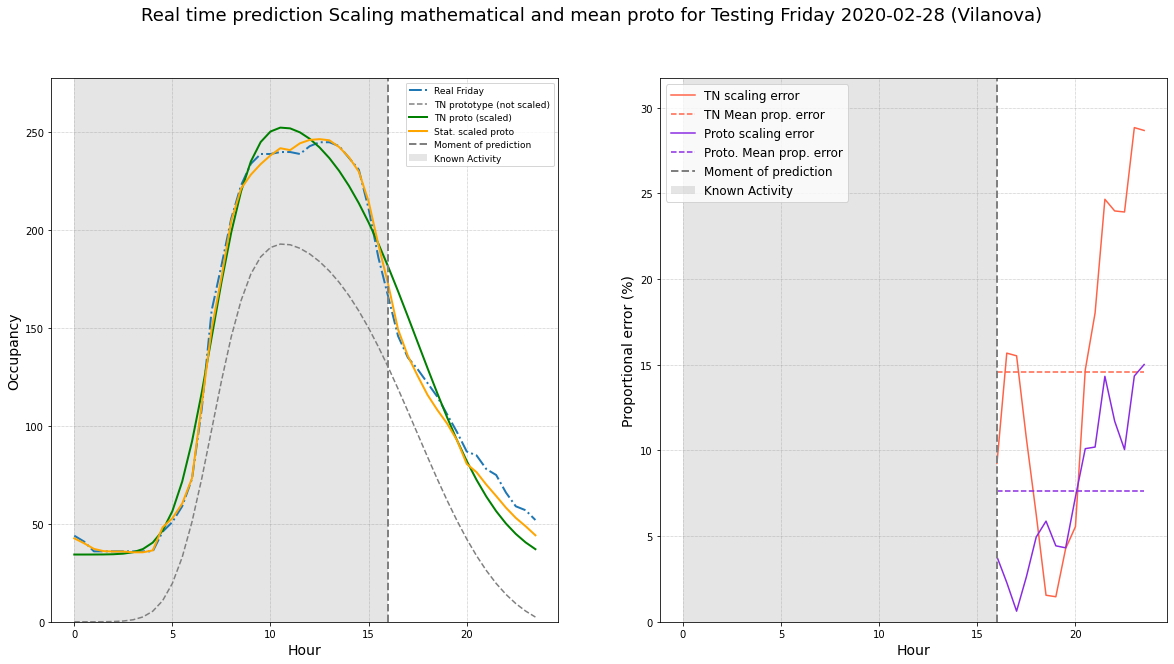

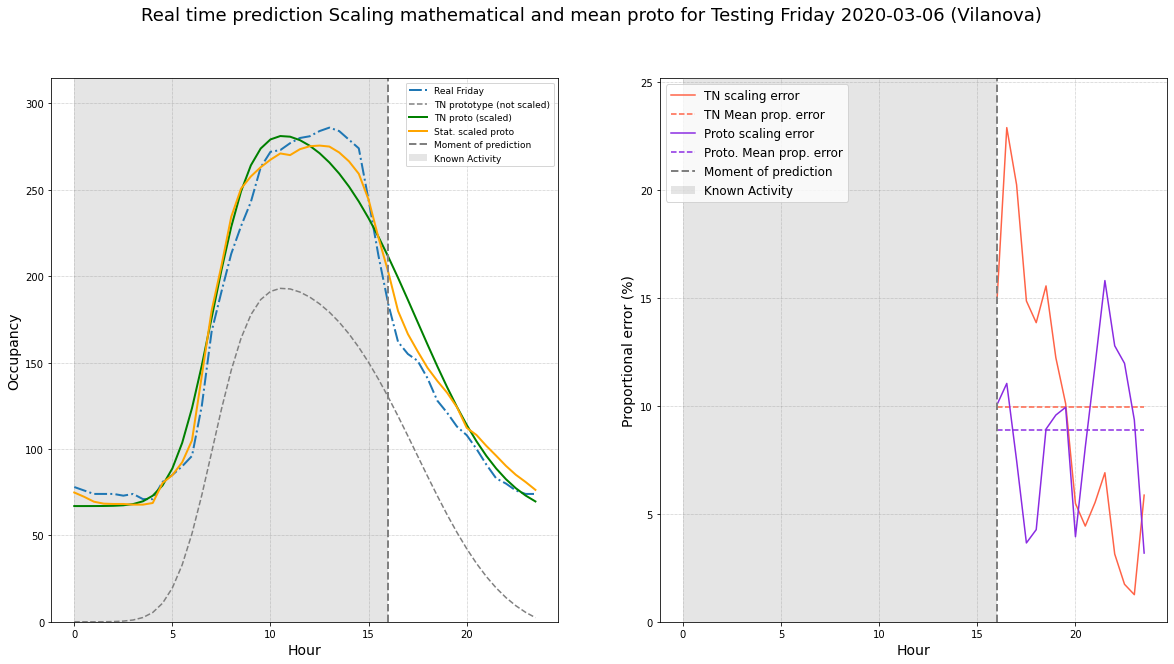

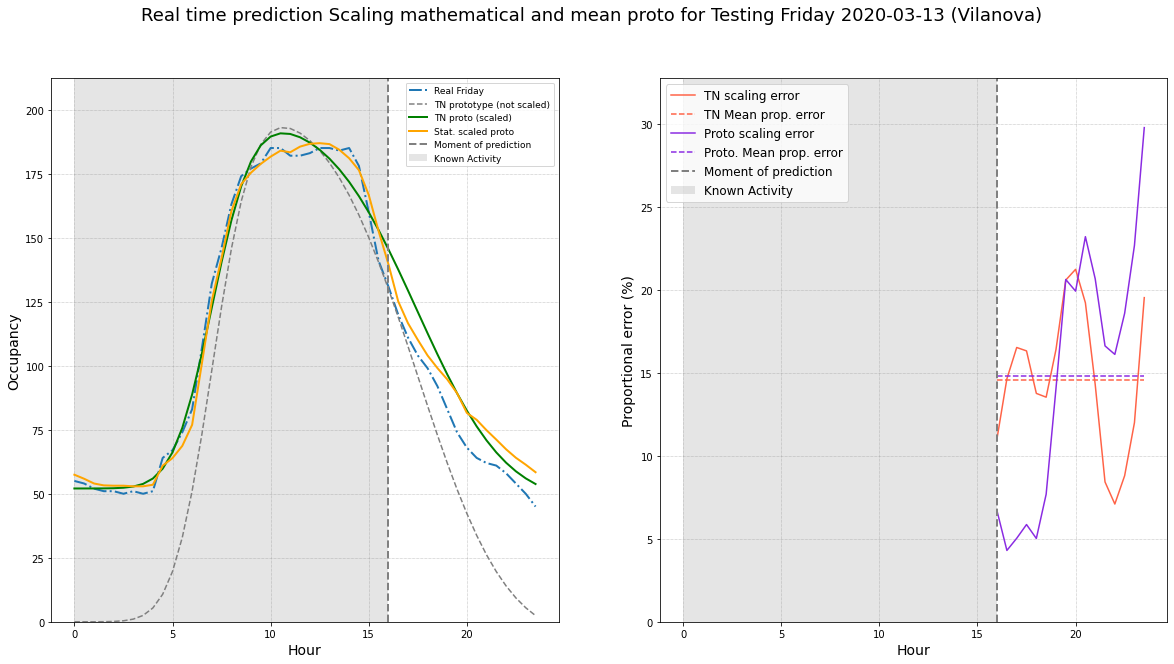

In [56]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

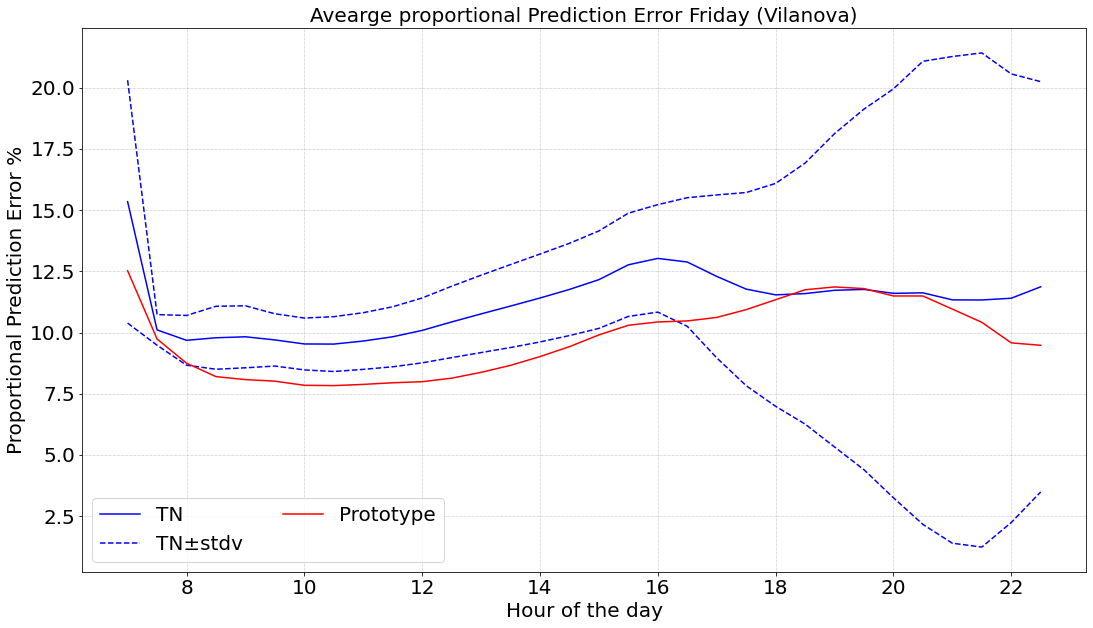

In [57]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
figH=plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [58]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

2020-02-28
Real Friday scaled prtotype error:  6.33 %
Real Friday scaled prtotype STDV:  6.538920428126443
Real Friday scaled TN error:  4.39 %
Real Friday scaled TN STDV:  3.307720814401341
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  2.57 %
Real Friday scaled prtotype STDV:  2.1705211089429226
Real Friday scaled TN error:  9.21 %
Real Friday scaled TN STDV:  7.006064691147694
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  4.23 %
Real Friday scaled prtotype STDV:  2.9491041865118692
Real Friday scaled TN error:  6.15 %
Real Friday scaled TN STDV:  6.172586535861306
_____________________________________________________________


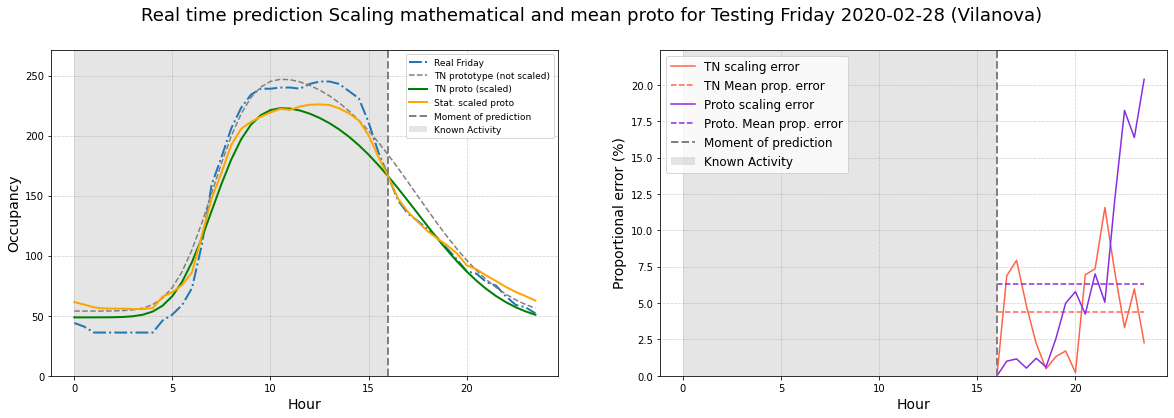

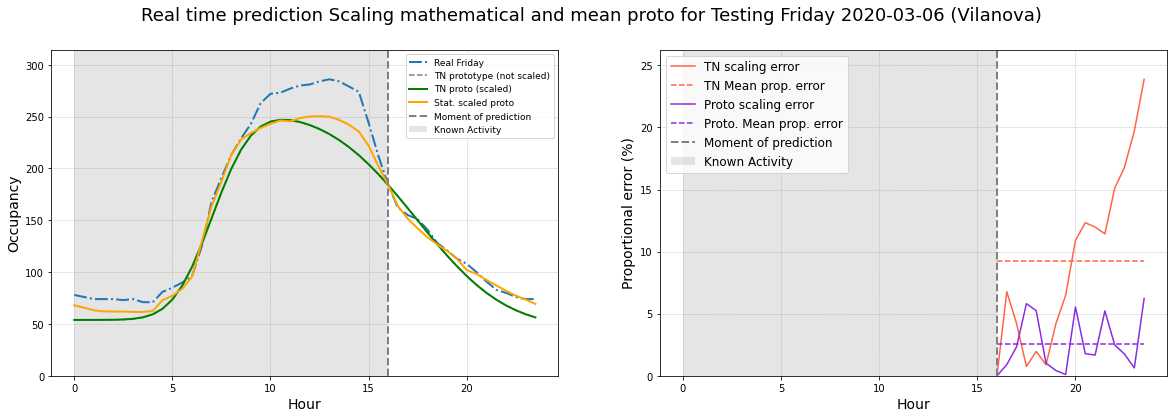

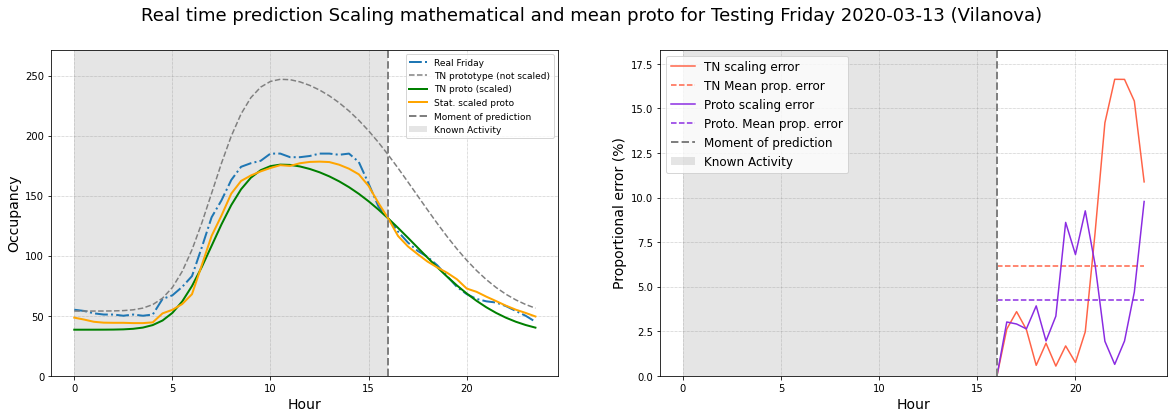

In [59]:
tn_proto = tn_friday 
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [60]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-29
Real Saturday scaled prtotype error:  9.66 %
Real Saturday scaled prtotype STDV:  4.915942274374522
Real Saturday scaled TN error:  11.0 %
Real Saturday scaled TN STDV:  6.005115491161298
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  10.75 %
Real Saturday scaled prtotype STDV:  2.7805992066487577
Real Saturday scaled TN error:  12.13 %
Real Saturday scaled TN STDV:  3.5130398384722072
_____________________________________________________________
2020-03-14
Real Saturday scaled prtotype error:  5.07 %
Real Saturday scaled prtotype STDV:  4.0129596820405204
Real Saturday scaled TN error:  5.59 %
Real Saturday scaled TN STDV:  3.1638644918798766
_____________________________________________________________


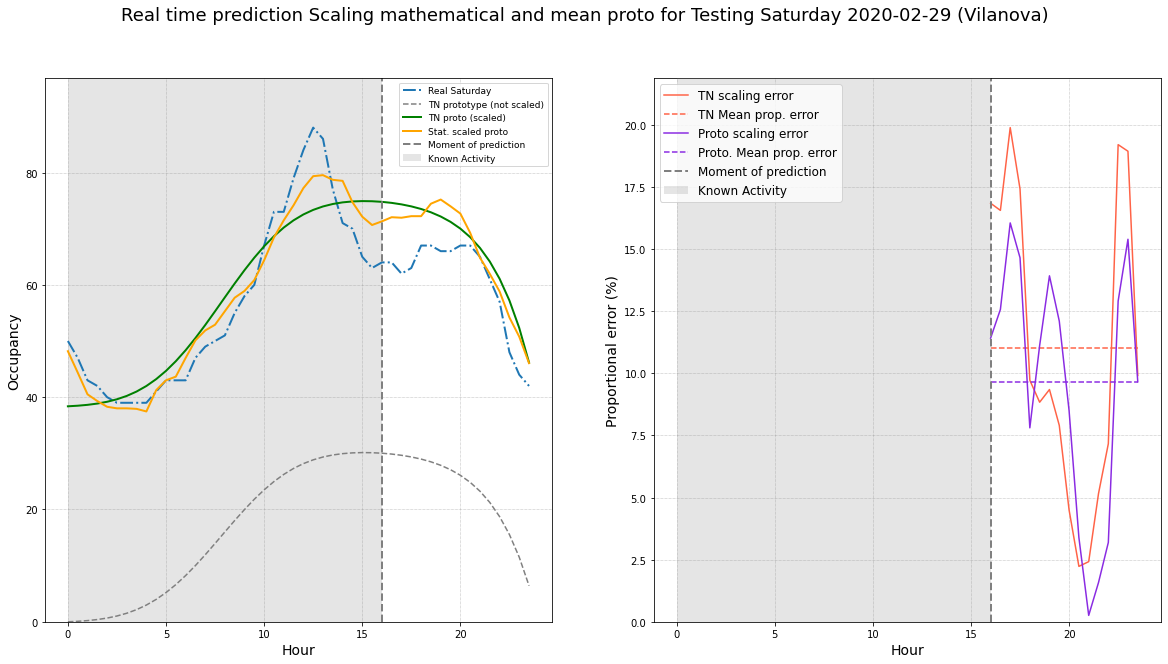

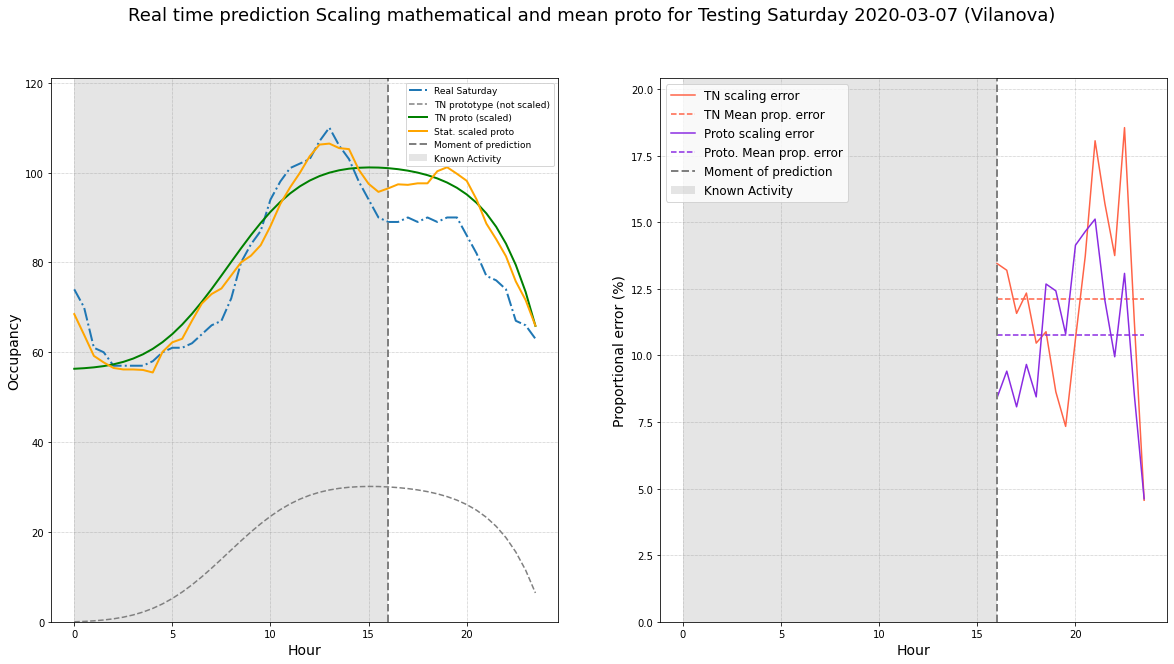

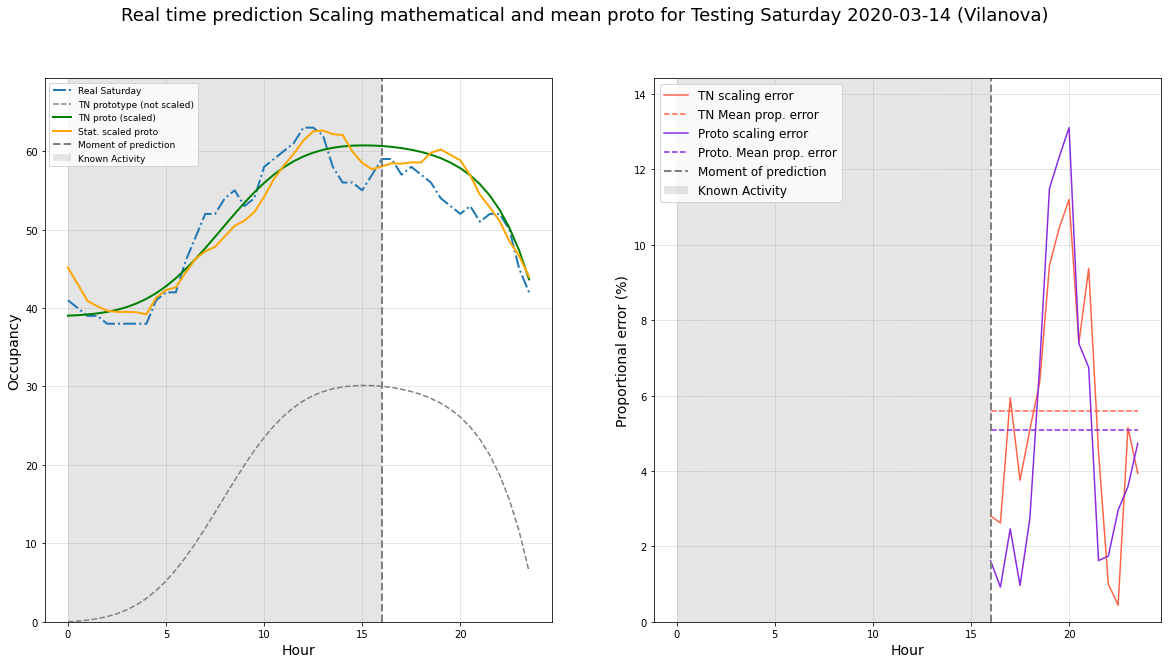

In [61]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

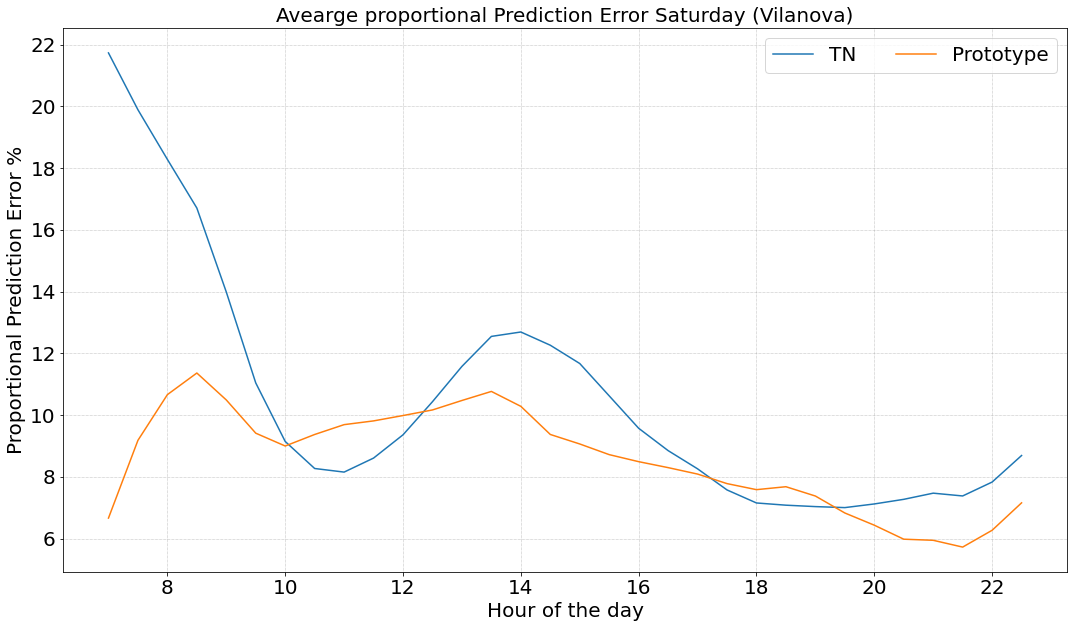

In [62]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [63]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-29
Real Saturday scaled prtotype error:  5.08 %
Real Saturday scaled prtotype STDV:  5.391224167220684
Real Saturday scaled TN error:  6.08 %
Real Saturday scaled TN STDV:  3.7237409313565055
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  4.4 %
Real Saturday scaled prtotype STDV:  3.5984161627393187
Real Saturday scaled TN error:  2.92 %
Real Saturday scaled TN STDV:  2.40331993845616
_____________________________________________________________
2020-03-14
Real Saturday scaled prtotype error:  6.14 %
Real Saturday scaled prtotype STDV:  4.8100663245085595
Real Saturday scaled TN error:  3.1 %
Real Saturday scaled TN STDV:  2.5377317628960365
_____________________________________________________________


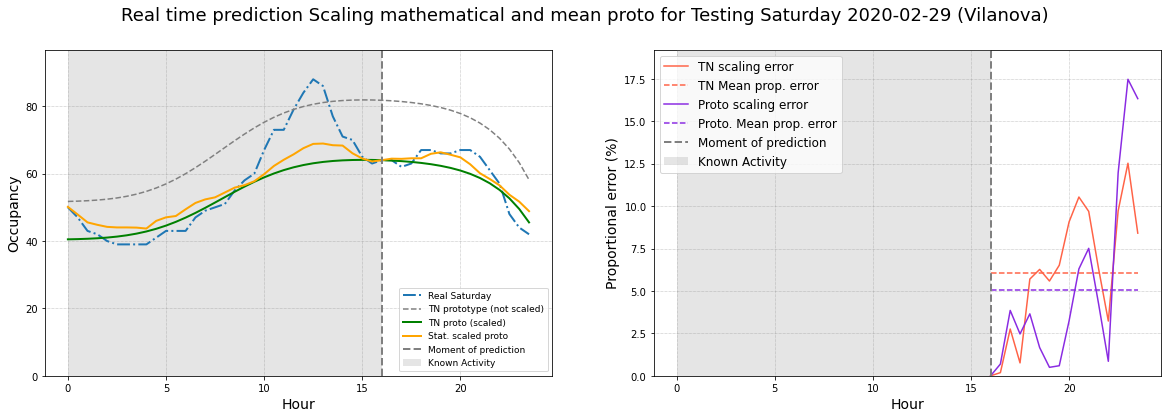

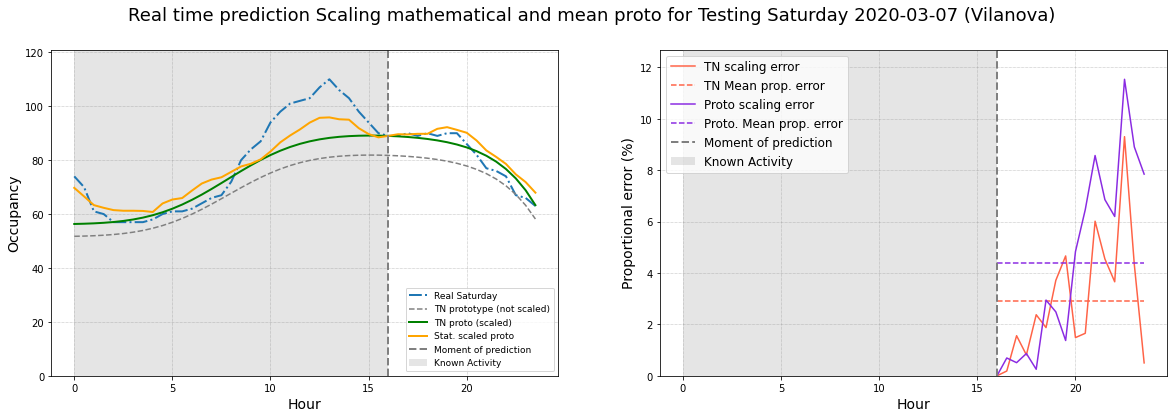

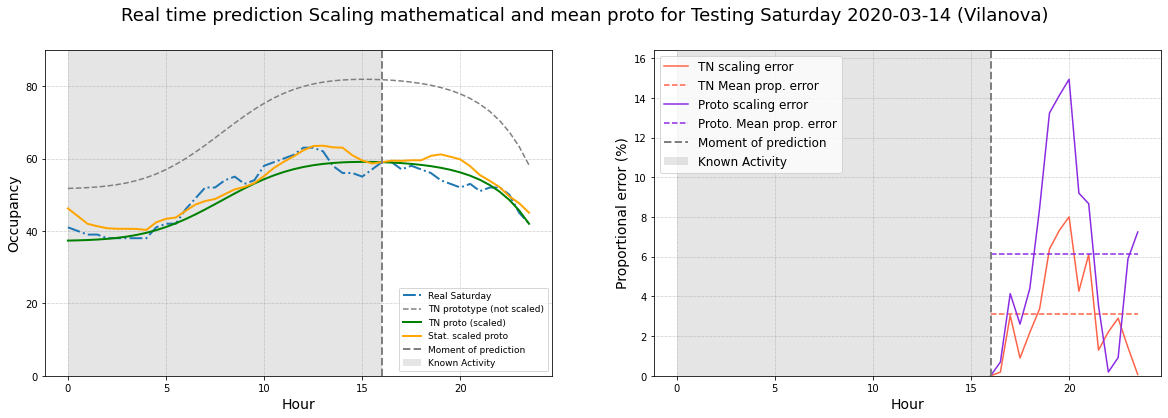

In [64]:
tn_proto = tn1_weekend        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [65]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    

2020-03-01
Real Sunday scaled prtotype error:  10.98 %
Real Sunday scaled prtotype STDV:  6.69032550187331
Real Sunday scaled TN error:  11.26 %
Real Sunday scaled TN STDV:  6.5074956334649
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  7.53 %
Real Sunday scaled prtotype STDV:  6.514432379093932
Real Sunday scaled TN error:  7.1 %
Real Sunday scaled TN STDV:  5.967257251924155
_____________________________________________________________
2020-03-15
Real Sunday scaled prtotype error:  6.96 %
Real Sunday scaled prtotype STDV:  3.285731973835862
Real Sunday scaled TN error:  6.09 %
Real Sunday scaled TN STDV:  3.4397886669758027
_____________________________________________________________


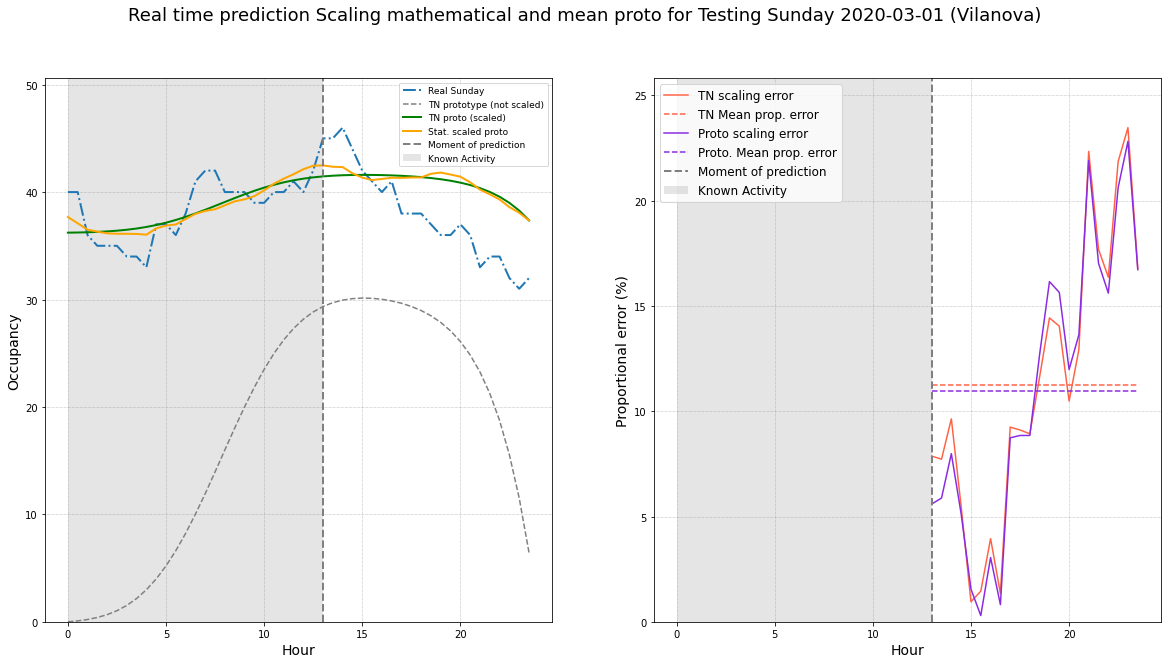

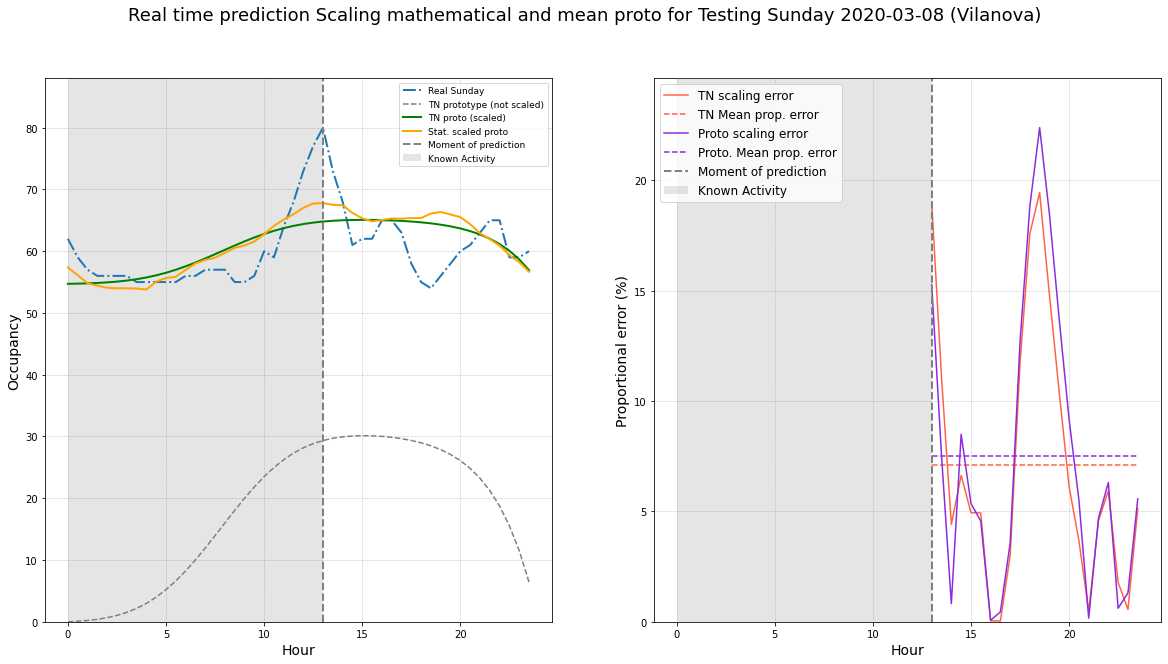

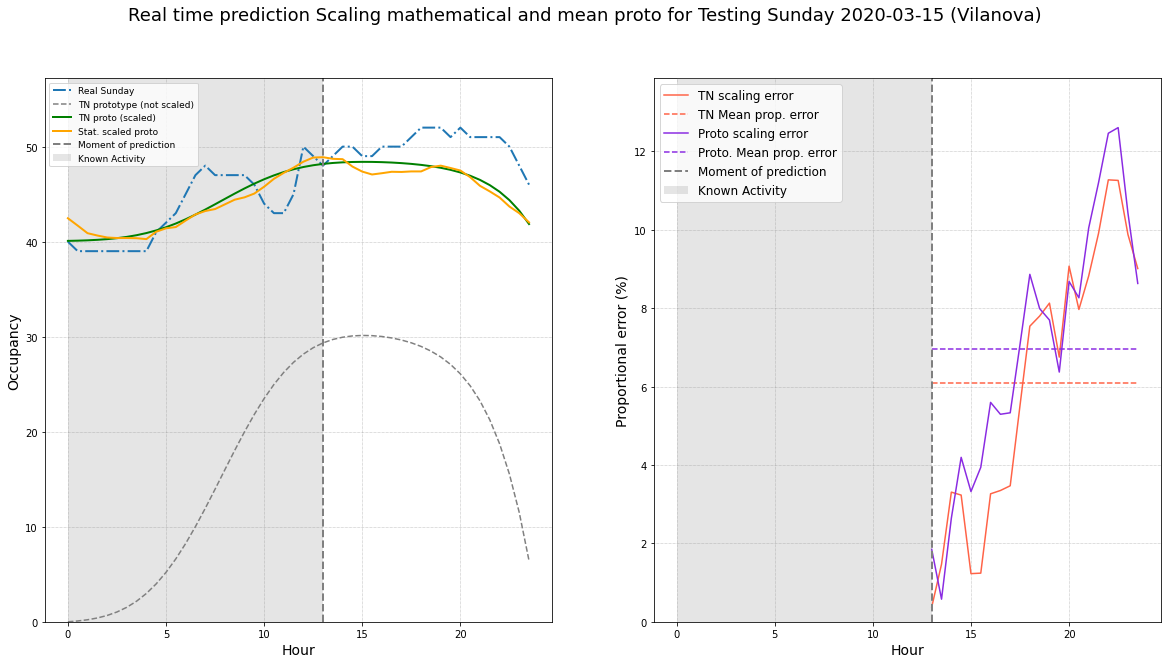

In [66]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

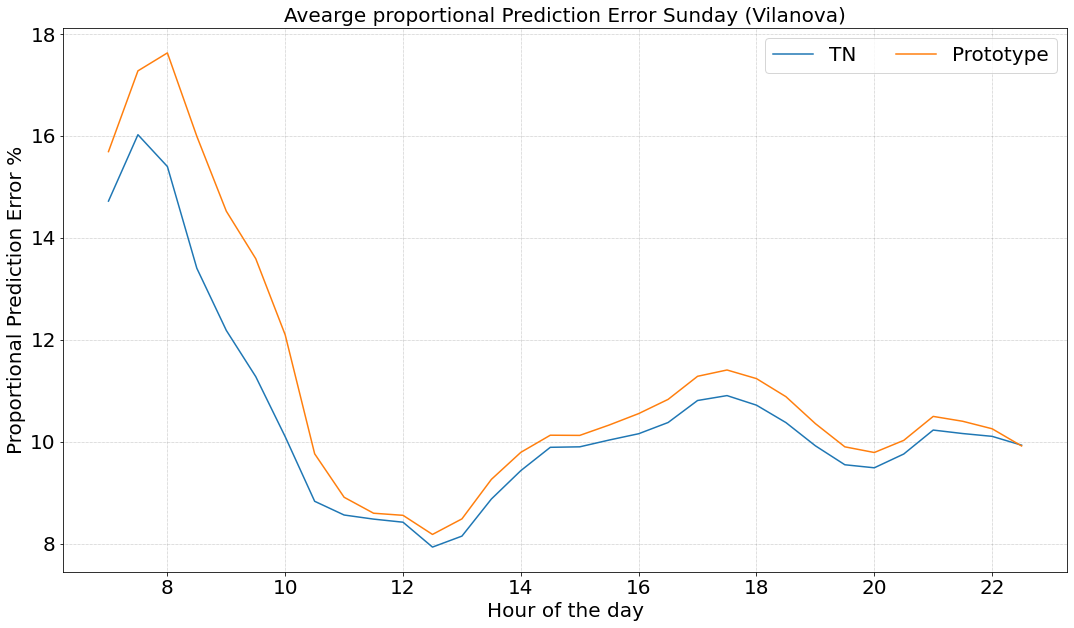

In [67]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [68]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

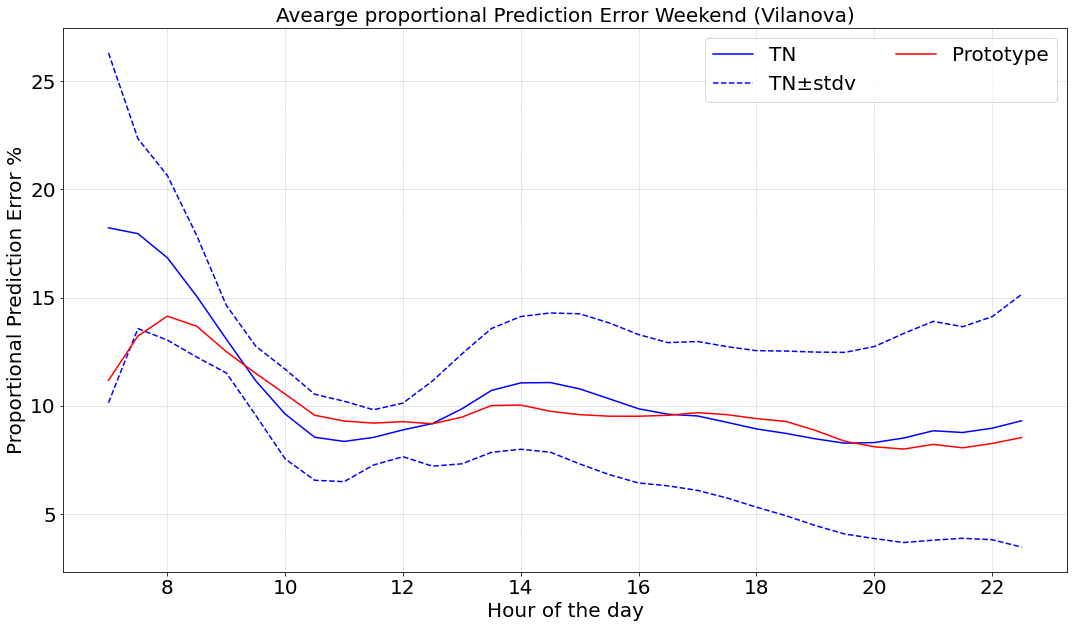

In [69]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

2020-03-01
Real Sunday scaled prtotype error:  8.58 %
Real Sunday scaled prtotype STDV:  6.58140792229619
Real Sunday scaled TN error:  13.35 %
Real Sunday scaled TN STDV:  7.7188687109355225
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  17.64 %
Real Sunday scaled prtotype STDV:  12.117859879136324
Real Sunday scaled TN error:  23.19 %
Real Sunday scaled TN STDV:  13.180608280368874
_____________________________________________________________
2020-03-15
Real Sunday scaled prtotype error:  13.12 %
Real Sunday scaled prtotype STDV:  6.96912892091627
Real Sunday scaled TN error:  8.97 %
Real Sunday scaled TN STDV:  7.200481278082755
_____________________________________________________________


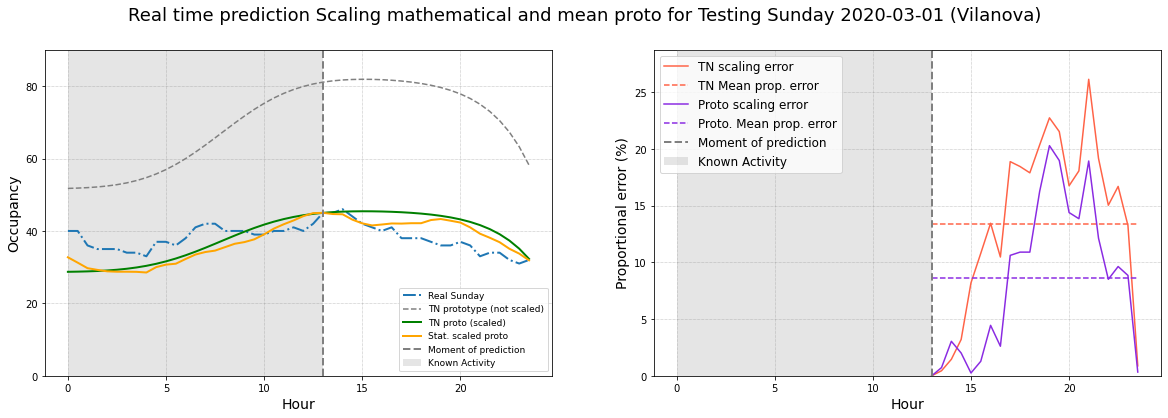

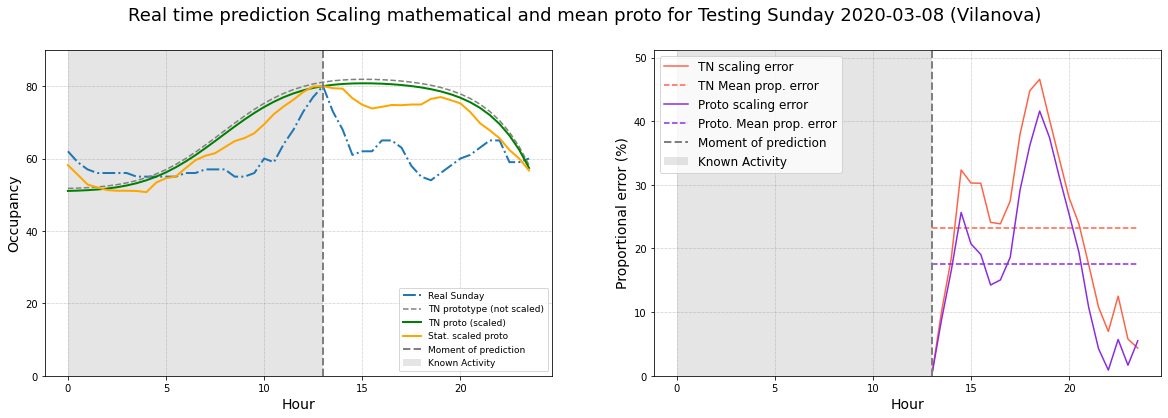

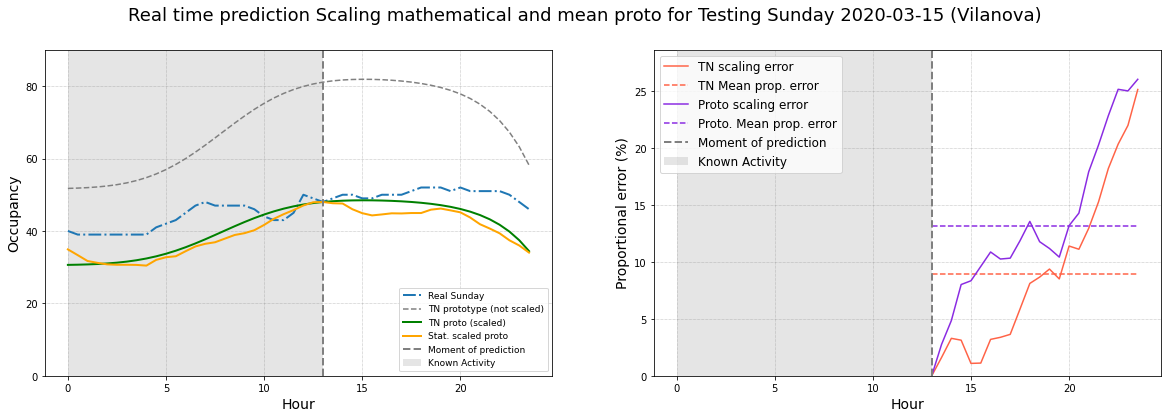

In [70]:
tn_proto = tn1_weekend
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

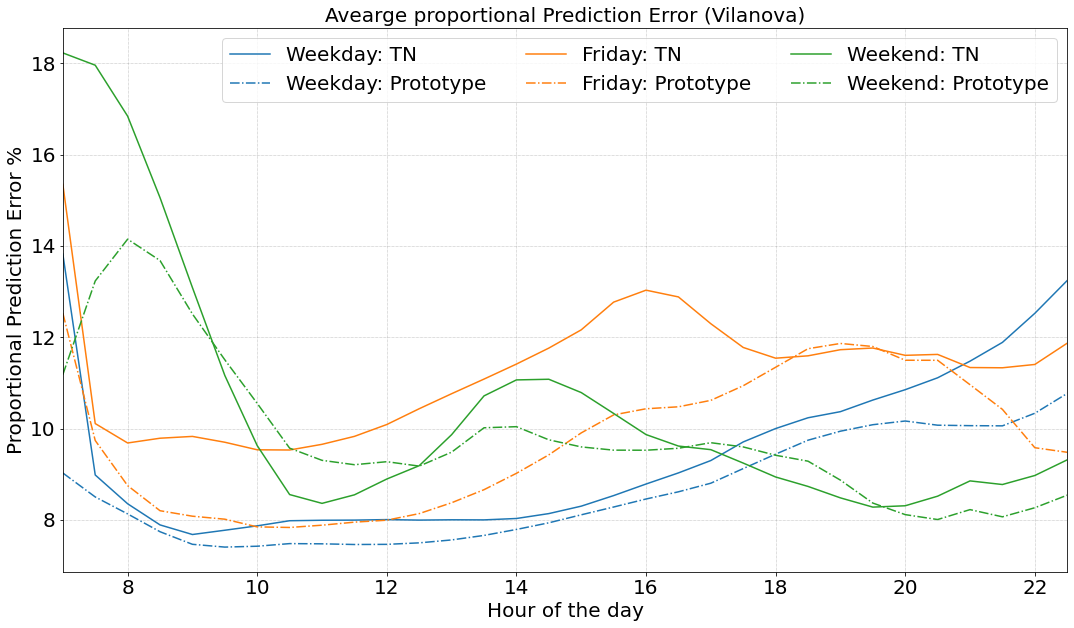

In [71]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'.pdf',bbox_inches='tight');